# Проект 4 Банковский скоринг
![](https://nacredit.ru/wp-content/uploads/2019/10/skoring.jpg)


В рамках проекта необходимо разработать модель, предсказывающую вероятность дефолта по кредиту на основании имеющихся анкетных данных и данных об итогах уже выданных кредитов.

# 1. Подготовка к работе
## 1.1 Импорт необходимых библиотек

In [593]:
from pandas import Series
import pandas as pd
import numpy as np

import pandas_profiling

from datetime import datetime, timedelta

import itertools

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.preprocessing import LabelEncoder, StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression


from sklearn.metrics import confusion_matrix
from sklearn.metrics import auc, roc_auc_score, roc_curve
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score 
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.feature_selection import RFE

from sklearn.model_selection import GridSearchCV



/kaggle/input/sf-dst-scoring/train.csv
/kaggle/input/sf-dst-scoring/test.csv
/kaggle/input/sf-dst-scoring/sample_submission.csv


In [594]:
# Зафиксируем Random_seed для воспроизводимости экспериментов
random_seed = 42 

In [595]:
# Зафиксируем версию пакетов для воспроизводимости экспериментов
!pip freeze > requirements.txt

## 1.2 Определение функций

In [597]:
# Визуализация числовых данных
def graph_num(col, size = 6):
    fig, (g1, g2) = plt.subplots(1, 2, figsize = (2*size,size))
    fig.suptitle('Histogram and boxplot for {0} '.format(col), fontsize=20)
    g1.hist(df[col], bins = 20, histtype = 'bar', align = 'mid', rwidth = 0.8, color = 'blue') # гистограмма
    g2.boxplot(df[col], vert = False)  # выбросы
    plt.figtext(0.5, 0, col, fontsize = 16)
    plt.show

In [598]:
# Статистические данные по выбросам
def statistic(col):
    median = df[col].median()
    IQR = df[col].quantile(0.75) - df[col].quantile(0.25)
    perc25 = df[col].quantile(0.25)
    perc75 = df[col].quantile(0.75)
    l=perc25 - 1.5*IQR 
    r=perc75 + 1.5*IQR
    print("Для {0} IQR: {1}, ".format(col,IQR),"Границы выбросов: [{0}, {1}].".format(l, r))
    print('Всего {} выбросов'.format(df[df[col] > r][col].count()+df[df[col] < l][col].count()))

In [599]:
#Таблица метрик модели
def metrics_total(y_true, y_pred, y_pred_prob):
    """Функция выводит в виде датафрейма значения основных метрик классификации"""
    dct_metrics = {}
    P = np.sum(y_true==1)
    N = np.sum(y_true==0)
    TP = np.sum((y_true==1)&(y_pred==1))
    TN = np.sum((y_true==0)&(y_pred==0))
    FP = np.sum((y_true==0)&(y_pred==1))
    FN = np.sum((y_true==1)&(y_pred==0))
    
    dct_metrics['P'] = ['Positive', P,'Дефолт']
    dct_metrics['N'] = ['Negative', N,'БЕЗ дефолта']
    dct_metrics['TP'] = ['True positive', TP,'Истинно дефолтные']
    dct_metrics['TN'] = ['True Negative', TN,'Истинно НЕ дефолтные']
    dct_metrics['FP'] = ['False Positive', FP,'Ложно дефолтные']
    dct_metrics['FN'] = ['False Negative', FN,'Ложно НЕ дефолтные']
    dct_metrics['Accuracy'] = ['Accuracy', accuracy_score(y_true, y_pred),'Accuracy=(TP+TN)/(TP+TN+FP+FN)']
    dct_metrics['Precision'] = ['Precision',precision_score(y_true, y_pred),'Точность = TP/(TP+FP)'] 
    dct_metrics['Recall'] = ['Recall', recall_score(y_true, y_pred),'Полнота = TP/(TP+FN)']
    dct_metrics['F1-score'] = ['F-мера', f1_score(y_true, y_pred),'Среднее гармоническое Precision и Recall']
    dct_metrics['ROC_AUC'] = ['ROC_AUC', roc_auc_score(y_true, y_pred_prob),'ROC-AUC']    

    temp_df = pd.DataFrame.from_dict(dct_metrics, orient='index', columns=['Metrics', 'Result', 'Description'])
    display(temp_df) 


In [600]:
#Таблица метрик для сравнения результатов каждой модели
def cumulated_res(data, col, y_true, y_pred, y_pred_prob):
    dct = {}
    dct['Accuracy'] = ['Accuracy', accuracy_score(y_true, y_pred)]
    dct['Precision'] = ['Precision',precision_score(y_true, y_pred)] 
    dct['Recall'] = ['Recall', recall_score(y_true, y_pred)]
    dct['F1-score'] = ['F1-score', f1_score(y_true, y_pred)]
    dct['ROC_AUC'] = ['ROC_AUC', roc_auc_score(y_true, y_pred_prob)]    
    temp_cum_df = pd.DataFrame.from_dict(dct, orient='index', columns=['Metrics', col])
    data = data.merge(temp_cum_df, on = 'Metrics')
    return data

In [601]:
#График confusion matrix
def conf_matr(y_true, y_pred):
    color_text = plt.get_cmap('Dark2')(0.95)
    class_names = ['Default', 'Non-Default']
    cm = confusion_matrix(y_true, y_pred)
    cm[0,0], cm[1,1] = cm[1,1], cm[0,0]
    data = pd.DataFrame(cm, index=class_names, columns=class_names)
    
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set(xticks=np.arange(cm.shape[1]), yticks=np.arange(cm.shape[0]), title="Confusion Matrix")
    ax.title.set_fontsize(15)
    group_names = ['TP','FP','FN','TN']
    sns.heatmap(data, square=True, annot=True,annot_kws={"size": 20}, fmt="d", linewidths=1, cmap="Pastel1")
    plt.setp(ax.get_yticklabels(), rotation=0, ha="right", rotation_mode="anchor", fontsize=12)
    plt.setp(ax.get_xticklabels(), rotation=0, ha="center", rotation_mode="anchor", fontsize=12)
    ax.set_ylabel('Predicted Values', fontsize=14, color = color_text)
    ax.set_xlabel('Real Values', fontsize=14, color = color_text)
    b, t = plt.ylim()
    plt.ylim(b+0.5, t-0.5)
    fig.tight_layout()
    plt.show()

In [602]:
#Кривая ROC_AUC
def roc_curv(y_true, y_pred_prob):
    fpr, tpr, _ = roc_curve(y_true, y_pred_prob)
    plt.figure()
    plt.plot([0, 1], label='Случайный классификатор', linestyle='--')
    plt.plot(fpr, tpr, label = 'Логистическая регрессия')
    plt.title('Логистическая регрессия ROC AUC = %0.3f' % roc_auc_score(y_true, y_pred_prob))
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.legend(loc = 'lower right')
    plt.show()

In [603]:
#График Precision_recall
def recall_precision_plot(y_test, y_pred):
    precisions, recalls, _ = precision_recall_curve(y_test, y_pred)
    ap = average_precision_score(y_test, y_pred)        
    plt.figure()
    plt.step(recalls, precisions, color='b', alpha=0.2, where='post')
    plt.fill_between(recalls, precisions, step='post', alpha=0.2, color='blue')
    plt.xlabel('Recall');
    plt.ylabel('Precision');
    plt.title('Recall-precision curve, площадь под кривой = %0.10f' % ap)
    plt.grid(True)
    plt.show()

# 2. Импорт, обзор и очистка данных
Данные представлены в виде выложенных на kaggle двух датасетов c данными и одного датасета для представления на соревнование. Известно, что в данных должны быть следующие признаки:

***client_id*** - идентификатор клиента

***education*** - уровень образования

***sex*** - пол заемщика

***age*** - возраст заемщика

***car***- флаг наличия автомобиля

***car_type*** - флаг автомобиля иномарки

***decline_app_cnt*** - количество отказанных прошлых заявок

***good_work*** - флаг наличия “хорошей” работы

***bki_request_cnt*** - количество запросов в БКИ

***home_address*** - категоризатор домашнего адреса

***work_address*** - категоризатор рабочего адреса

***income***- доход заемщика

***foreign_passport*** - наличие загранпаспорта

***sna*** - связь заемщика с клиентами банка

***first_time*** - давность наличия информации о заемщике

***score_bki*** - скоринговый балл по данным из БКИ

***region_rating*** - рейтинг региона

***app_date*** - дата подачи заявки

***default*** - флаг дефолта по кредиту


Все датасеты предложены в формате csv. Загрузим датасеты и сделаем первичный осмотр.

## 2.1 Предварительный обзор

In [604]:
df_test = pd.read_csv('test.csv')
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36349 entries, 0 to 36348
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   client_id         36349 non-null  int64  
 1   app_date          36349 non-null  object 
 2   education         36178 non-null  object 
 3   sex               36349 non-null  object 
 4   age               36349 non-null  int64  
 5   car               36349 non-null  object 
 6   car_type          36349 non-null  object 
 7   decline_app_cnt   36349 non-null  int64  
 8   good_work         36349 non-null  int64  
 9   score_bki         36349 non-null  float64
 10  bki_request_cnt   36349 non-null  int64  
 11  region_rating     36349 non-null  int64  
 12  home_address      36349 non-null  int64  
 13  work_address      36349 non-null  int64  
 14  income            36349 non-null  int64  
 15  sna               36349 non-null  int64  
 16  first_time        36349 non-null  int64 

In [605]:
df_test.head()

client_id   app_date education sex  age car car_type  decline_app_cnt  \
0      74835  22MAR2014       GRD   M   29   Y        Y                0   
1      17527  24JAN2014       SCH   F   39   N        N                5   
2      75683  23MAR2014       UGR   M   50   Y        Y                0   
3      26883  03FEB2014       SCH   M   56   N        N                0   
4      28862  04FEB2014       GRD   F   38   N        N                0   

   good_work  score_bki  bki_request_cnt  region_rating  home_address  \
0          0  -2.271884                3             50             1   
1          0  -1.504999                2             50             1   
2          0  -1.691339                1             50             1   
3          0  -2.374182                1             40             1   
4          0  -2.487502                0             80             2   

   work_address  income  sna  first_time foreign_passport  
0             2   50000    1           4                N  
1             2    5000    4           3                N  
2             2   30000    1           3                Y  
3             2   17000    1           3                N  
4             3  120000    1           3                N

In [606]:
df_train = pd.read_csv('train.csv')
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73799 entries, 0 to 73798
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   client_id         73799 non-null  int64  
 1   app_date          73799 non-null  object 
 2   education         73492 non-null  object 
 3   sex               73799 non-null  object 
 4   age               73799 non-null  int64  
 5   car               73799 non-null  object 
 6   car_type          73799 non-null  object 
 7   decline_app_cnt   73799 non-null  int64  
 8   good_work         73799 non-null  int64  
 9   score_bki         73799 non-null  float64
 10  bki_request_cnt   73799 non-null  int64  
 11  region_rating     73799 non-null  int64  
 12  home_address      73799 non-null  int64  
 13  work_address      73799 non-null  int64  
 14  income            73799 non-null  int64  
 15  sna               73799 non-null  int64  
 16  first_time        73799 non-null  int64 

In [607]:
df_train.head()

client_id   app_date education sex  age car car_type  decline_app_cnt  \
0      25905  01FEB2014       SCH   M   62   Y        Y                0   
1      63161  12MAR2014       SCH   F   59   N        N                0   
2      25887  01FEB2014       SCH   M   25   Y        N                2   
3      16222  23JAN2014       SCH   F   53   N        N                0   
4     101655  18APR2014       GRD   M   48   N        N                0   

   good_work  score_bki  bki_request_cnt  region_rating  home_address  \
0          0  -2.008753                1             50             1   
1          0  -1.532276                3             50             2   
2          0  -1.408142                1             80             1   
3          0  -2.057471                2             50             2   
4          1  -1.244723                1             60             2   

   work_address  income  sna  first_time foreign_passport  default  
0             2   18000    4           1                N        0  
1             3   19000    4           1                N        0  
2             2   30000    1           4                Y        0  
3             3   10000    1           3                N        0  
4             3   30000    1           4                Y        0

In [608]:
df_smp = pd.read_csv('sample_submission.csv')
df_smp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24354 entries, 0 to 24353
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   client_id  24354 non-null  int64  
 1   default    24354 non-null  float64
dtypes: float64(1), int64(1)
memory usage: 380.7 KB


In [609]:
df_smp.head()

client_id   default
0      66799  0.441004
1      25379  0.138092
2      28825  0.373370
3      37530  0.476501
4       4264  0.304640

In [610]:
#Для корректной обработки/очистки признаков объединяем трейн и тест в один датасет.
df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0 # помечаем где у нас тест
df_test['default'] = 0 # мы должны предсказать default, поэтому пока просто заполняем тестовую часть нулями

df = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем

In [611]:
print('Датасет df_train имеет размерность ', df_train.shape)
print('Датасет df_test имеет размерность ', df_test.shape)
print('Датасет df имеет размерность ', df.shape)

Датасет df_train имеет размерность  (73799, 20)
Датасет df_test имеет размерность  (36349, 20)
Датасет df имеет размерность  (110148, 20)


In [612]:
df.describe()

client_id            age  decline_app_cnt      good_work  \
count  110148.000000  110148.000000    110148.000000  110148.000000   
mean    55074.500000      39.249410         0.273205       0.165514   
std     31797.133063      11.518063         0.799099       0.371645   
min         1.000000      21.000000         0.000000       0.000000   
25%     27537.750000      30.000000         0.000000       0.000000   
50%     55074.500000      37.000000         0.000000       0.000000   
75%     82611.250000      48.000000         0.000000       0.000000   
max    110148.000000      72.000000        33.000000       1.000000   

           score_bki  bki_request_cnt  region_rating   home_address  \
count  110148.000000    110148.000000  110148.000000  110148.000000   
mean       -1.904535         2.005002      56.751189       1.574945   
std         0.499397         2.266926      13.065923       0.527562   
min        -3.624586         0.000000      20.000000       1.000000   
25%        -2.260434         0.000000      50.000000       1.000000   
50%        -1.920823         1.000000      50.000000       2.000000   
75%        -1.567888         3.000000      60.000000       2.000000   
max         0.199773        53.000000      80.000000       3.000000   

        work_address          income            sna     first_time  \
count  110148.000000   110148.000000  110148.000000  110148.000000   
mean        2.497867    41012.648537       1.731588       2.765570   
std         0.687651    45399.735051       1.122652       1.010151   
min         1.000000     1000.000000       1.000000       1.000000   
25%         2.000000    20000.000000       1.000000       2.000000   
50%         3.000000    30000.000000       1.000000       3.000000   
75%         3.000000    48000.000000       2.000000       4.000000   
max         3.000000  1000000.000000       4.000000       4.000000   

              sample        default  
count  110148.000000  110148.000000  
mean        0.669999       0.085086  
std         0.470215       0.279010  
min         0.000000       0.000000  
25%         0.000000       0.000000  
50%         1.000000       0.000000  
75%         1.000000       0.000000  
max         1.000000       1.000000

In [613]:
df.sample(5)

client_id   app_date education sex  age car car_type  decline_app_cnt  \
21899       17387  24JAN2014       UGR   F   55   N        N                0   
11509       45624  21FEB2014       UGR   M   32   N        N                0   
103750      49878  26FEB2014       SCH   F   37   N        N                0   
61134       10437  17JAN2014       GRD   M   51   Y        Y                0   
88943       56739  05MAR2014       GRD   F   57   N        N                0   

        good_work  score_bki  bki_request_cnt  region_rating  home_address  \
21899           0  -2.532887                3             50             1   
11509           0  -0.910691                0             80             2   
103750          1  -1.183934                2             50             1   
61134           0  -1.526422                0             40             1   
88943           0  -2.235505                1             40             2   

        work_address  income  sna  first_time foreign_passport  sample  \
21899              2   58000    1           4                N       0   
11509              3   50000    4           1                N       0   
103750             1   12000    1           1                N       1   
61134              1   75000    1           3                N       1   
88943              3    9500    2           4                N       1   

        default  
21899         0  
11509         0  
103750        0  
61134         0  
88943         0

Опишем объединённый датасет с помощью библиотеки ***pandas_profiling***. Данная библиотека позволяет одной командой получить информацию по каждой колонке датасета. Данные уже сгруппированы в удобном для аналитика формате, а также визуализированы с помощью встроенных в библиотеку графиков matplotlib. Отчёт сразу позволяет принять решение об очистке данных. При необходимости отчёт может быть представлен в виде HTML файла. 

***ВАЖНО***: этот отчёт даёт предварительную информацию о признаках. Серьёзная очистка данных производится вручную индивидуально для каждого признака.

In [614]:
pandas_profiling.ProfileReport(df)

#Результат нужно немного пролистать до заголовка Overview

/opt/conda/lib/python3.7/site-packages/IPython/core/display.py:701: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


Отчёт показал следующие результаты:

В датасете на более чем 100 тысяч записей 478 пропусков,  дальше будет видно, в каких они столбцах.

В датасете 7 числовых столбцов, 7 категориальных и 7 булевых (бинарных). Интересно, что отчёт выделяет категориальные столбцы даже среди данные, представленных числами. Бинарные также представляют как числовые, так и буквенные флаги. Обсудим что выдал отчёт по каждому столбцу.

***client_id*** - идентификатор клиента. Самое главное - все данные уникальны и не имеют пропусков. Это, в частности, означает, что результаты модели будут "честными" - тестироваться она будет на данных, которые ещё не встречались. Также мы видим, что id клиента по сути - порядковый номер записи в датасете.

***app_date*** - дата подачи заявки. Пропусков нет. Запись в строковом формате. Тот факт, что все записи имеют одинаковую длину 9 знаков, указывает на то, что данные внесены качественно, без "сюрпризов" и явных опечаток. В столбце 120 уникальных значений, можно предположить, что мы анализируем данные за 4 месяца. Уточнить это можно будет после преобразования. Обращает на себя внимание тот факт, что можно выделить 11 дат, когда заявок было подано особенно много. В дальнейшем можно будет попробовать использовать эту информацию для конструирования дополнительного признака. 

***education*** - уровень образования. Очевидно, что это единственный столбец с пропусками, т.к. все 478 пропущенных значений подсчитаны здесь. Всего имеется 5 категорий образования. В дальнейшем будет необходимо заполнить пропуски.

***sex*** - пол заявителя. Здесь всё предсказуемо: две категории, пропусков нет. Интересно, что женщин среди заявителей немного больше.

***age*** - возраст заемщика. Без пропусков, разброс от 21 до 72 лет. Основная масса заёмщиков находится в возрасте 30-48 лет.

***car*** - флаг наличия автомобиля. Без пропусков, бинарное значение.

***car_type*** - флаг автомобиля иномарки.Без пропусков, бинарное значение. Этот столбец является продолжением предыдущего. Вероятнее всего, лица, не имеющие никакого автомобиля и по категории "иномарка" получают значение "нет". Это подтверждает и количество в категории "N".

***decline_app_cnt*** - количество отказанных прошлых заявок. Важный параметр для будущей модели. Пропусков нет, зато есть выбросы, которые придётся убрать. Некий герой получил 33 отказа, причём 95% получили менее 2.

***good_work*** - флаг наличия “хорошей” работы. Бинарная функция без пропусков. Обработки не требует.

***score_bki*** - скоринговый балл по данным из БКИ. Пропусков нет. Значения отрицательные и положительные, непрерывные. Гистограмма визуально выглядит как нормальное распределение. Можно предположить, что этот признак будет очень важен для построения модели.

***bki_request_cnt*** - количество запросов в БКИ. Данные без пропусков. Здесь также будут выбросы, т.к. при среднем количестве 2 максимум представляет собой 53.

***region_rating*** - рейтинг региона. Данные без пропусков, разбиты на 7 категорий от 20 до 80. Чаще всего встречается категория 60.

***home_address*** и ***work_address*** - категоризатор домашнего и рабочего адреса. Данные без пропусков, 3 категории. Что в них зашифровано, неясно. Нужно будет оценивать влияние признака на модель. 

***income*** - доход заемщика.Несомненно важная категория. Пропусков нет. Судя по данным статистики, бОльшая часть заёмщиков имеет доход до 100 т.р. В данных будут выбросы, необходимо будет обработать.

***sna*** - связь заемщика с клиентами банка. Категориальная переменная без пропусков и явных выбросов. Предварительная интерпретация не ясна. 

***first_time*** - давность наличия информации о заемщике. Категориальная переменная без пропусков. Интересно будет посмотреть её взаимосвязь с датой запроса и прочими признаками.

***foreign_passport*** - наличие загранпаспорта. Бинарная переменная без пропусков. Нужно будет перевести буквенный флаг в цифры.

Столбцы ***default*** и ***sample*** пропусков не имеют. 

Также в отчёте представлены корреляции по разным критериям, но удобнее будет их построить позднее, добавив в матрицу числовые значения.

## 2.2 Обработка и очистка отдельных столбцов
### Столбец client_id
Значения столбца уникальны, не имеют пропусков. Для модели они не потребуются, поэтому в списках столбцов для анализа и преобразования он учитываться не будет. Вернёмся к этому столбцу при работе с моделью, т.к. данные клиентов нужны будут для submission.


### Обработаем столбец app_date

Как уже было сказано выше, есть 11 дат, в которые анкеты подавались значительно чаще прочих 109 дней. Сразу выделим отдельный признак app_pop, с флагом, относится ли дата к этой частой категории или нет. Впоследствии, если этот признак окажется несущественным, то мы его удалим.

In [615]:
#Создадим список из 11 самых частых дат
lst = list(df['app_date'].value_counts().index[:11]) 
#Расставим флаг с помощью лямбда-функции и проверим результат
df['app_pop'] = df['app_date'].apply(lambda x: 1 if x in lst else 0) 
df['app_pop'].value_counts()

0    95855
1    14293
Name: app_pop, dtype: int64

Сделаем столбец с датами, преобразованными в datetime

In [616]:
df['app_cld'] = pd.to_datetime(df.app_date, format='%d%b%Y')
df['app_cld'].describe(datetime_is_numeric=True)

count                           110148
mean     2014-03-02 23:18:54.633425920
min                2014-01-01 00:00:00
25%                2014-02-03 00:00:00
50%                2014-03-04 00:00:00
75%                2014-03-31 00:00:00
max                2014-04-30 00:00:00
Name: app_cld, dtype: object

Как и предполагалось, датасет содержит данные за 4 месяца. Теперь мы можем точно сказать период:  с января по апрель 2014 года.

Посмотрим общее распределение.

Text(0, 0.5, 'Number of Applications')

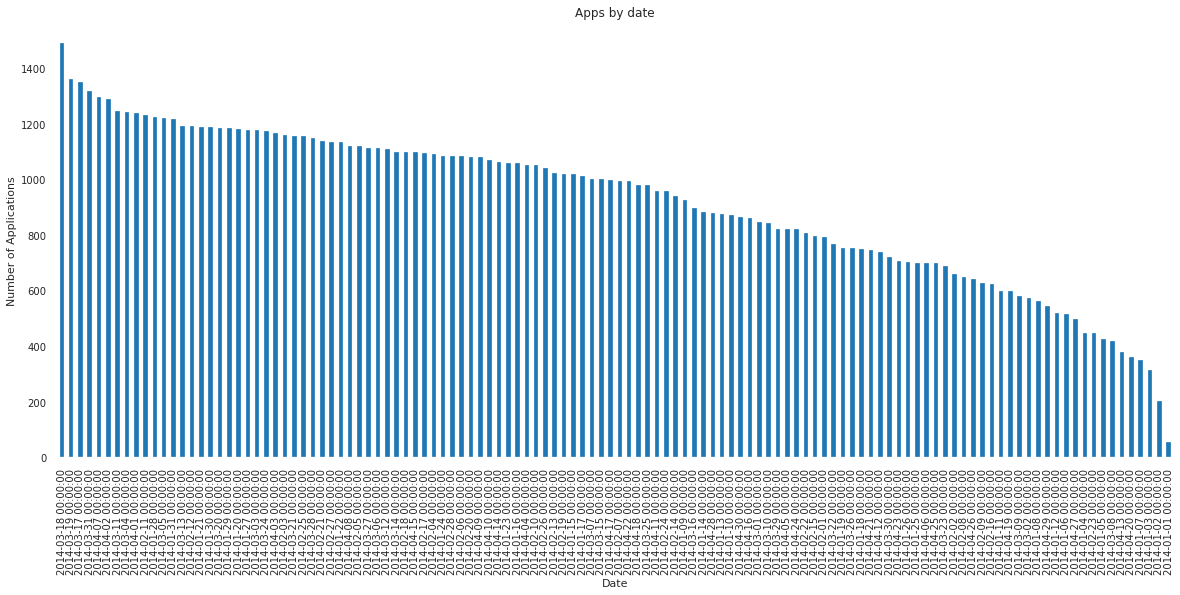

In [617]:
plt.title('Apps by date')

df['app_cld'].value_counts().plot(kind='bar',figsize=(20,8))
plt.xlabel('Date')
plt.ylabel('Number of Applications')

Визуально распределение не идеально равномерное. 11 самых частых дат мы уже выделили в признак. Кстати, на графике они тоже неплохо отсекаются. Попробуем понять, что влияло на количество заявок.

Посмотрим распределение по месяцам.

Text(0, 0.5, 'Number of Applications')

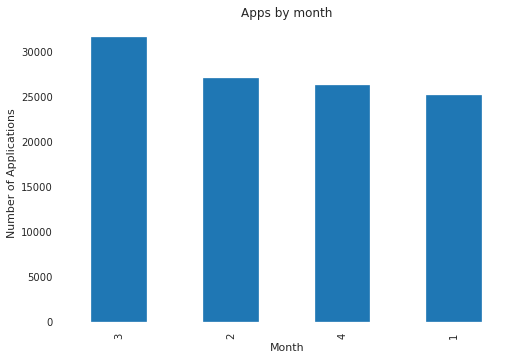

In [618]:
plt.title('Apps by month')
df['app_cld'].dt.month.value_counts().plot(kind='bar')
plt.xlabel('Month')
plt.ylabel('Number of Applications')



Относительно равномерно, хотя март явно лидирует. 
Попробуем посмотреть распределение по дням недели.

Text(0, 0.5, 'Number of Applications')

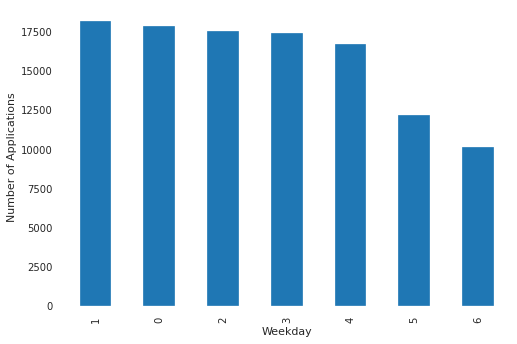

In [619]:
df['app_day'] = df['app_cld'].apply(lambda x: datetime.weekday(x))
df['app_day'].value_counts().plot(kind='bar')
plt.xlabel('Weekday')
plt.ylabel('Number of Applications')


В модуле datetime по умолчанию за 0 указывают понедельник. Количество заявок предсказуемо меньше с пятницы по воскресенье. 

Добавим столбец с месяцами и удалим исходные столбцы app_date и app_cld, т.к. при дальнейшем преобразовании они вряд ли будут полезны. 

In [620]:
df['app_mth'] = df['app_cld'].dt.month
df['app_mth'].value_counts()

3    31597
2    27097
4    26266
1    25188
Name: app_mth, dtype: int64

In [621]:
df.drop(['app_date', 'app_cld'], axis='columns', inplace=True)


In [622]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110148 entries, 0 to 110147
Data columns (total 22 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   client_id         110148 non-null  int64  
 1   education         109670 non-null  object 
 2   sex               110148 non-null  object 
 3   age               110148 non-null  int64  
 4   car               110148 non-null  object 
 5   car_type          110148 non-null  object 
 6   decline_app_cnt   110148 non-null  int64  
 7   good_work         110148 non-null  int64  
 8   score_bki         110148 non-null  float64
 9   bki_request_cnt   110148 non-null  int64  
 10  region_rating     110148 non-null  int64  
 11  home_address      110148 non-null  int64  
 12  work_address      110148 non-null  int64  
 13  income            110148 non-null  int64  
 14  sna               110148 non-null  int64  
 15  first_time        110148 non-null  int64  
 16  foreign_passport  11

### Обработаем столбец education
В этом столбце выявлены пропуски. Посмотрим их долю и подумаем, как их можно заполнить.

In [623]:
print('В столбце education пропущено {} % позиций'.format(df['education'].isnull().sum()/len(df.education)*100))

В столбце education пропущено 0.4339615789664814 % позиций


In [624]:
df[df['education'].isna()].sample(15)

client_id education sex  age car car_type  decline_app_cnt  good_work  \
47650       15947       NaN   M   52   N        N                0          0   
10143       59359       NaN   M   34   Y        Y                0          0   
3132        73818       NaN   F   22   N        N                0          0   
18654       27959       NaN   M   25   Y        Y                0          1   
11352      103578       NaN   M   53   Y        N                0          0   
66178       32473       NaN   M   30   Y        Y                0          1   
94847        1781       NaN   F   45   N        N                0          0   
90208       19630       NaN   M   51   N        N                0          0   
56325       96443       NaN   M   52   Y        Y                0          0   
53487       12597       NaN   F   42   N        N                0          0   
105395      10776       NaN   M   34   N        N                1          1   
8025        26218       NaN   F   43   N        N                0          0   
42288       94643       NaN   F   50   N        N                0          0   
58744        7406       NaN   F   39   N        N                1          0   
42271       61641       NaN   M   35   Y        Y                0          0   

        score_bki  bki_request_cnt  ...  work_address  income  sna  \
47650   -2.419731                2  ...             3   12000    1   
10143   -1.373510                0  ...             3  250000    2   
3132    -1.626151                0  ...             3   20000    2   
18654   -1.777894                2  ...             3   24000    4   
11352   -1.681712                2  ...             3  150000    1   
66178   -1.687190                1  ...             2   30000    2   
94847   -1.756954                0  ...             3   30000    1   
90208   -2.447239                0  ...             3   10000    4   
56325   -2.008121                0  ...             3   40000    1   
53487   -0.572845                0  ...             3   35000    1   
105395  -2.260096                1  ...             1   47000    1   
8025    -2.365999                2  ...             3   50000    1   
42288   -2.119627                2  ...             1   25000    1   
58744   -1.366932                3  ...             3   20000    1   
42271   -2.468437                2  ...             1   45000    1   

        first_time  foreign_passport  sample default  app_pop  app_day  \
47650            4                 N       1       0        0        3   
10143            4                 Y       0       0        0        4   
3132             3                 N       0       0        0        4   
18654            3                 N       0       0        0        1   
11352            4                 Y       0       0        0        1   
66178            1                 Y       1       0        0        5   
94847            4                 N       1       0        0        0   
90208            1                 N       1       0        0        0   
56325            4                 N       1       0        0        6   
53487            3                 N       1       1        0        0   
105395           3                 N       1       0        0        5   
8025             1                 N       0       0        0        6   
42288            3                 Y       1       0        0        3   
58744            4                 N       1       0        0        1   
42271            4                 N       1       0        1        1   

        app_mth  
47650         1  
10143         3  
3132          3  
18654         2  
11352         4  
66178         2  
94847         1  
90208         1  
56325         4  
53487         1  
105395        1  
8025          2  
42288         4  
58744         1  
42271         3  

[15 rows x 22 columns]

Количество пропусков не дотягивает даже до 1 процента. Обучать модель в данном случае нецелесообразно. Поэтому заполним пропуски наиболее часто встречающимся значением.

In [625]:
x = df['education'].mode()[0]
x

'SCH'

In [626]:
df['education'].fillna(x, inplace=True)
df['education'].value_counts(dropna=False)

SCH    58476
GRD    34768
UGR    14748
PGR     1865
ACD      291
Name: education, dtype: int64

### Переведём все строковые значения в числа
Для этого используем LabelEncoder. Заметим, что за исключением education все строковые значения представляют собой бинарный флаг.

In [627]:
#Создаём список столбцов для преобразования
col_le = ['education', 'sex', 'car', 'car_type', 'foreign_passport']

#Вызываем LabelEncoder
le = LabelEncoder()

#Циклом переформатируем заданные столбцы
for col in col_le:
    le.fit(df[col]) 
    df[col] = le.transform(df[col])    

Создадим списки столбцов с числовыми (непрерывными), бинарными и категориальными признаками.

In [628]:
#Для начала убедимся, что у нас не осталось столбцов со строковыми значениями
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110148 entries, 0 to 110147
Data columns (total 22 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   client_id         110148 non-null  int64  
 1   education         110148 non-null  int64  
 2   sex               110148 non-null  int64  
 3   age               110148 non-null  int64  
 4   car               110148 non-null  int64  
 5   car_type          110148 non-null  int64  
 6   decline_app_cnt   110148 non-null  int64  
 7   good_work         110148 non-null  int64  
 8   score_bki         110148 non-null  float64
 9   bki_request_cnt   110148 non-null  int64  
 10  region_rating     110148 non-null  int64  
 11  home_address      110148 non-null  int64  
 12  work_address      110148 non-null  int64  
 13  income            110148 non-null  int64  
 14  sna               110148 non-null  int64  
 15  first_time        110148 non-null  int64  
 16  foreign_passport  11

## 2.3 Окончательная обработка столбцов для вставки в модель

In [629]:
#Посмотрим количество уникальных значений в столбцах
for col in df.columns:
    print('В столбце {0} {1} уникальных значений'.format(col, len(df[col].unique())))

В столбце client_id 110148 уникальных значений
В столбце education 5 уникальных значений
В столбце sex 2 уникальных значений
В столбце age 52 уникальных значений
В столбце car 2 уникальных значений
В столбце car_type 2 уникальных значений
В столбце decline_app_cnt 24 уникальных значений
В столбце good_work 2 уникальных значений
В столбце score_bki 102618 уникальных значений
В столбце bki_request_cnt 40 уникальных значений
В столбце region_rating 7 уникальных значений
В столбце home_address 3 уникальных значений
В столбце work_address 3 уникальных значений
В столбце income 1207 уникальных значений
В столбце sna 4 уникальных значений
В столбце first_time 4 уникальных значений
В столбце foreign_passport 2 уникальных значений
В столбце sample 2 уникальных значений
В столбце default 2 уникальных значений
В столбце app_pop 2 уникальных значений
В столбце app_day 7 уникальных значений
В столбце app_mth 4 уникальных значений


Разделим столбцы по следующему принципу: в бинарную категорию попадут столбцы, в которых два уникальных значения, в категорийные столбцы - от 3 до 7 значений, в числовые - более 7 значений.

In [630]:
#Создадим пустые списки
col_bin = [] # Бинарные
col_num = [] # Числовые
col_cat = [] # Категориальные

for col in df.columns:
    if len(df[col].unique()) == 2:
        col_bin.append(col)
    elif len(df[col].unique()) < 8:
        col_cat.append(col)

    else:
        col_num.append(col)

print(col_bin, col_num, col_cat)

['sex', 'car', 'car_type', 'good_work', 'foreign_passport', 'sample', 'default', 'app_pop'] ['client_id', 'age', 'decline_app_cnt', 'score_bki', 'bki_request_cnt', 'income'] ['education', 'region_rating', 'home_address', 'work_address', 'sna', 'first_time', 'app_day', 'app_mth']


### 2.3.1 Обработаем числовые столбцы


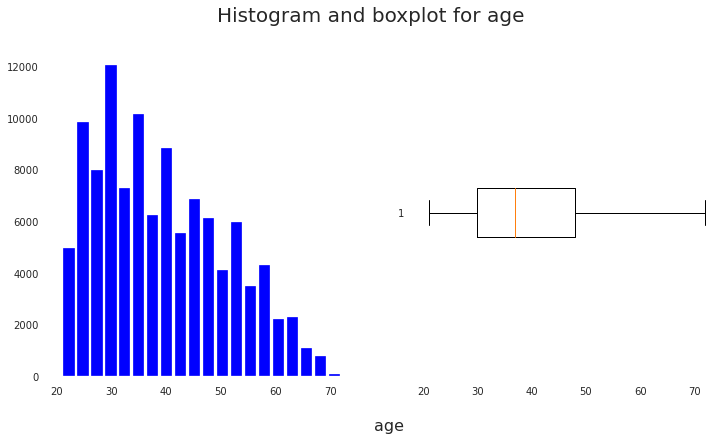

In [631]:
graph_num('age')

Прологарифмируем и посмотрим, есть ли изменения

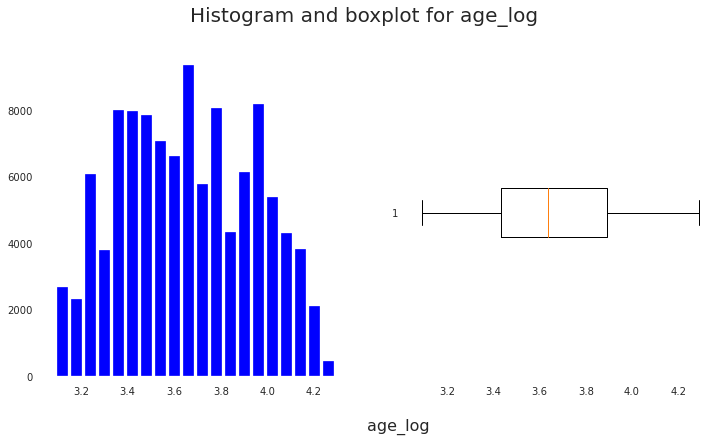

In [632]:
df['age_log'] = np.log(df['age'] + 1)
graph_num('age_log')

Распределение немного подровнялось, оставим в логарифмированном виде. 

In [633]:
df['age'] = df['age_log']
df.drop(['age_log'], axis = 1, inplace = True)

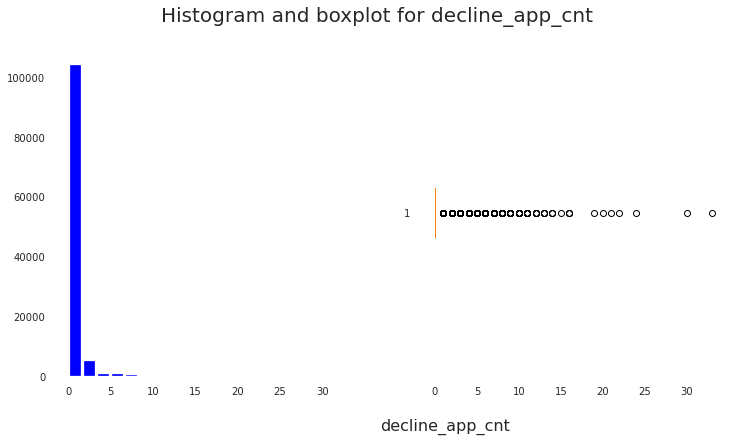

In [634]:
graph_num('decline_app_cnt')

Здесь мы видим, что  бОльшая часть результатов равняется 0, т.е. в основном отказов не было. Нормализация не даст ощутимого результата. Скорее стоит перевести сделать этот столбец категориальным, взяв за 0 отсутствие отказов, за 1 1-2  и за 2 3 и более.

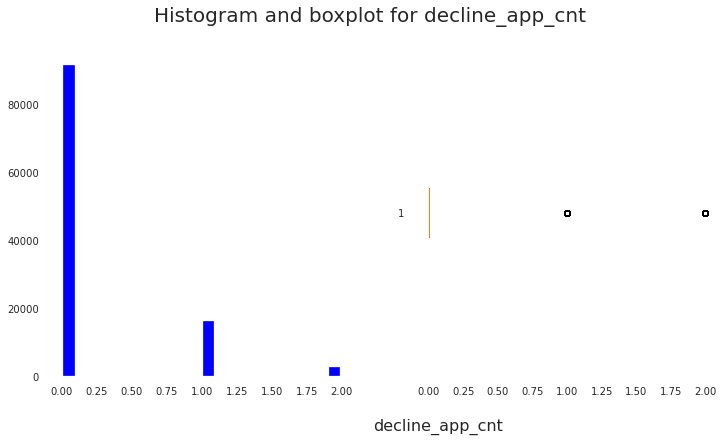

In [635]:
df['decline_app_cnt'] = df['decline_app_cnt'].apply(lambda x: 2 if x >=3 else (1 if x>0 else 0))
graph_num('decline_app_cnt')

Перенесём столбец decline_app_cnt в список категориальных столбцов

In [636]:
col_cat.append('decline_app_cnt')
col_num.remove('decline_app_cnt')

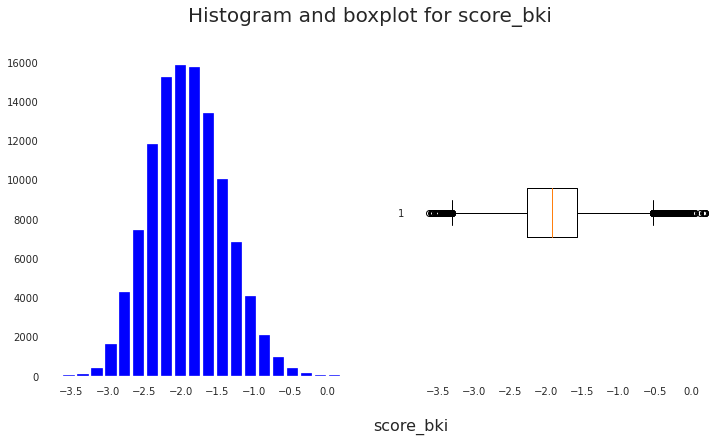

In [637]:
graph_num('score_bki')

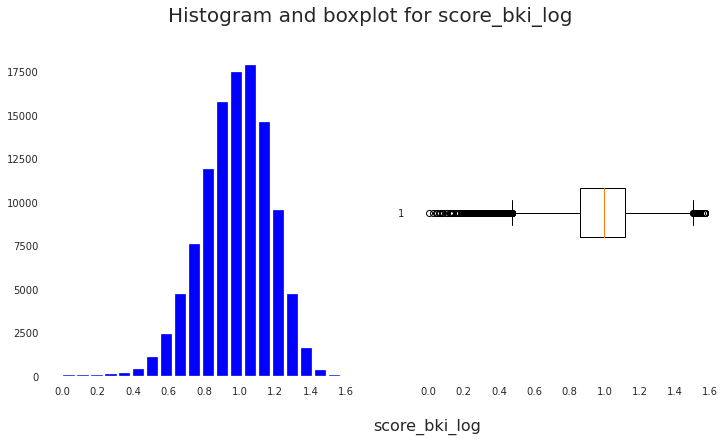

In [638]:
#Для того, чтобы появилась возможность логарифмировать, необходимо сделать данные положительными
df['score_bki'] = df['score_bki'] + abs(df['score_bki'].min())
df['score_bki_log'] = np.log(df['score_bki'] + 1)
graph_num('score_bki_log')

In [639]:
statistic('score_bki')
statistic('score_bki_log')

Для score_bki IQR: 0.6925455175000006,  Границы выбросов: [0.32533437374999896, 3.095516443750001].
Всего 518 выбросов
Для score_bki_log IQR: 0.25691563295687536,  Границы выбросов: [0.4750462207684304, 1.502708752595932].
Всего 712 выбросов


В итоге распределение сильно сместилось, а выбросов даже прибавилось. Поэтому оставляем как есть.

In [640]:
df.drop(['score_bki_log'], axis=1, inplace=True)

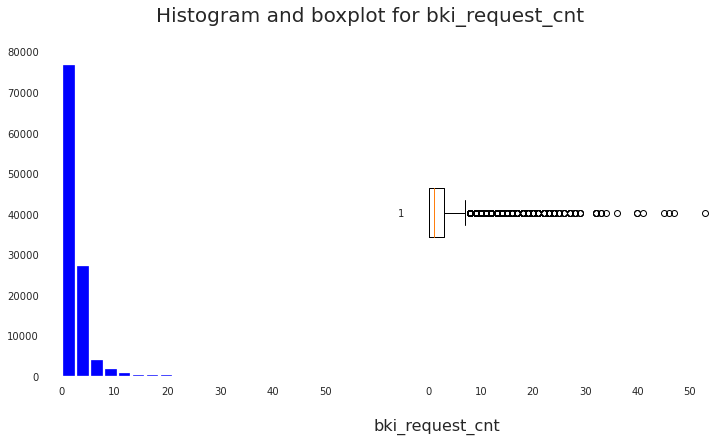

In [641]:
graph_num('bki_request_cnt')

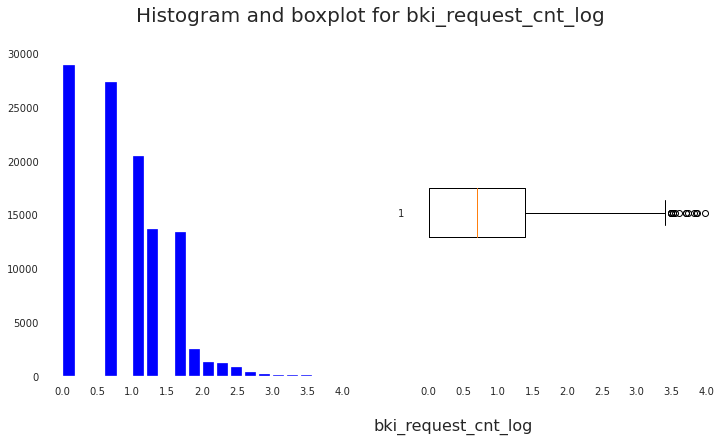

In [642]:
df['bki_request_cnt_log'] = np.log(df['bki_request_cnt'] + 1)
graph_num('bki_request_cnt_log')

In [643]:
statistic('bki_request_cnt')
statistic('bki_request_cnt_log')

Для bki_request_cnt IQR: 3.0,  Границы выбросов: [-4.5, 7.5].
Всего 2636 выбросов
Для bki_request_cnt_log IQR: 1.3862943611198906,  Границы выбросов: [-2.0794415416798357, 3.465735902799726].
Всего 15 выбросов


Количество выбросов радикально сократилось. Оставляем логарифмированный вариант

In [644]:
df['bki_request_cnt'] = df['bki_request_cnt_log']
df.drop(['bki_request_cnt_log'],axis=1, inplace=True)

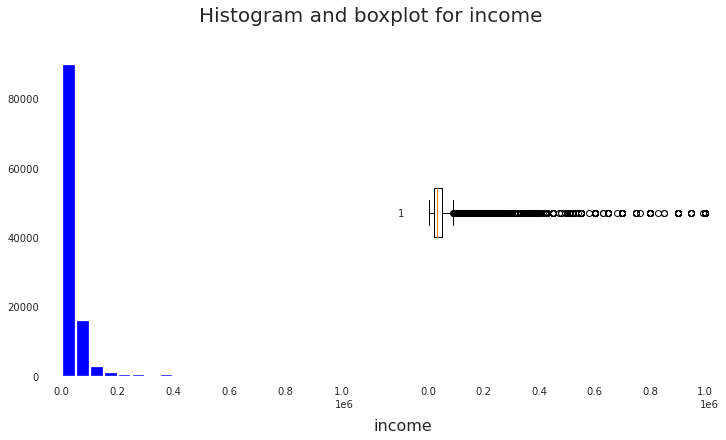

In [645]:
graph_num('income')

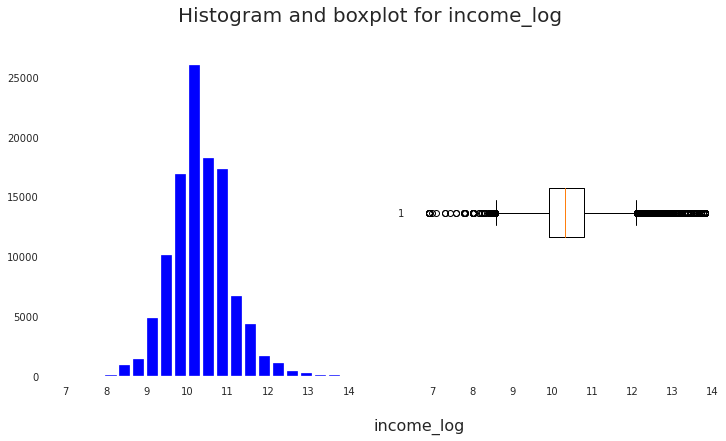

In [646]:
df['income_log'] = np.log(df['income'] + 1)
graph_num('income_log')

In [647]:
statistic('income')
statistic('income_log')

Для income IQR: 28000.0,  Границы выбросов: [-22000.0, 90000.0].
Всего 7000 выбросов
Для income_log IQR: 0.8754395717201806,  Границы выбросов: [8.590378193705899, 12.092136480586621].
Всего 2609 выбросов


Оставим логарифмированный вариант. Мы не можем однозначно утверждать,что люди с большим доходом не допускали дефолта, т.к. они могли брать бОльший кредит.

In [648]:
df['income'] = df['income_log']
df.drop(['income_log'], axis=1, inplace = True)

### Рассмотрим корреляции числовых признаков между собой

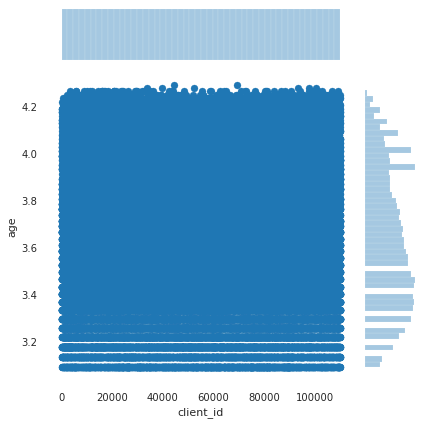

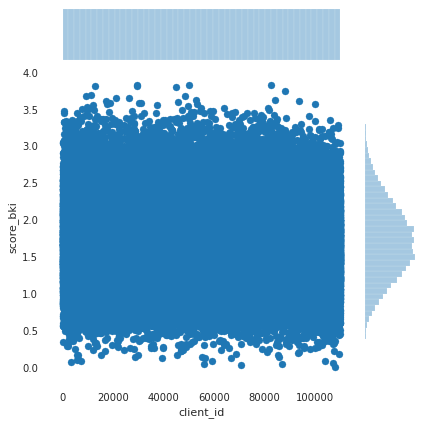

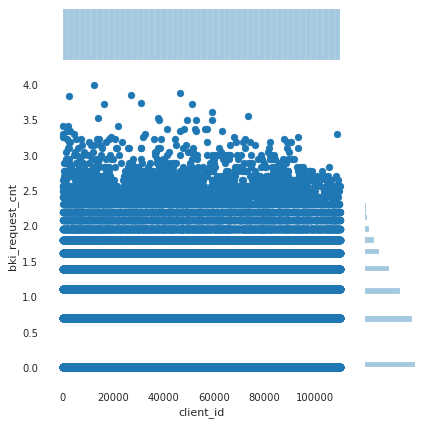

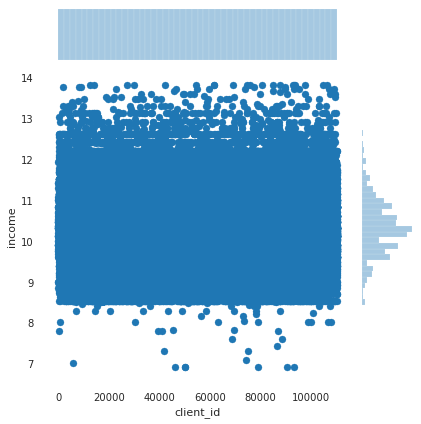

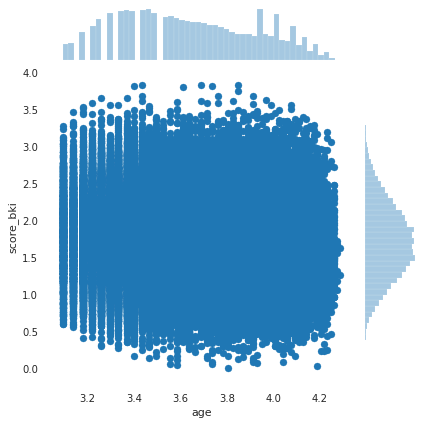

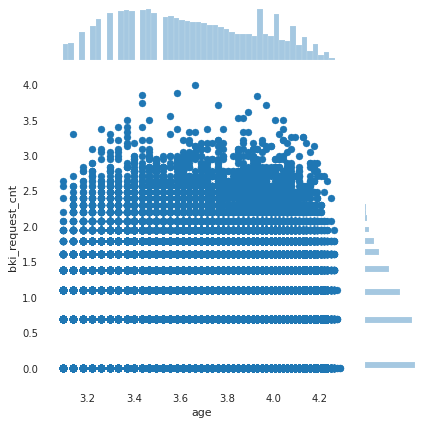

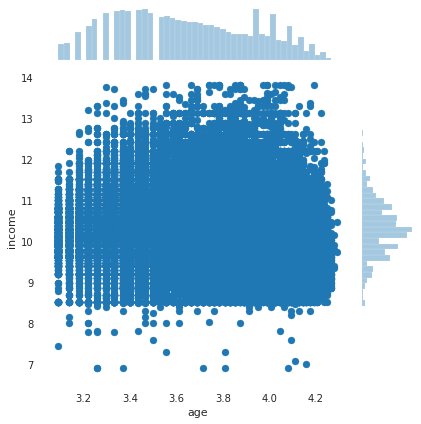

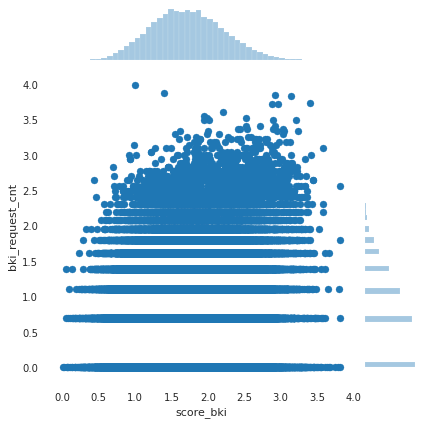

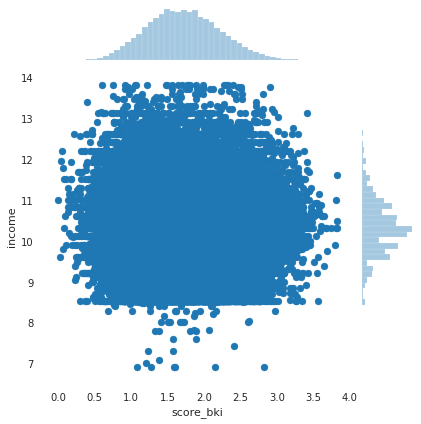

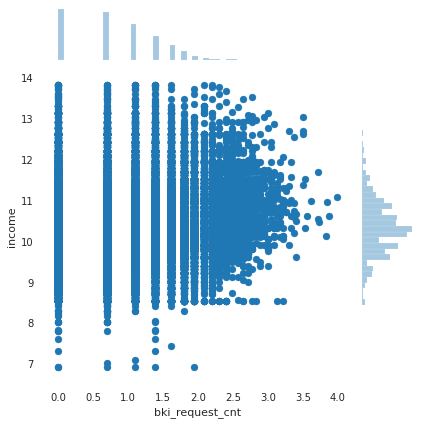

In [649]:
def jointplot(column1, column2):
    return sns.jointplot(x = column1, y = column2, data = df)

pairs = list(itertools.combinations(col_num,2))
for pair in pairs:
    jointplot(pair[0], pair[1])

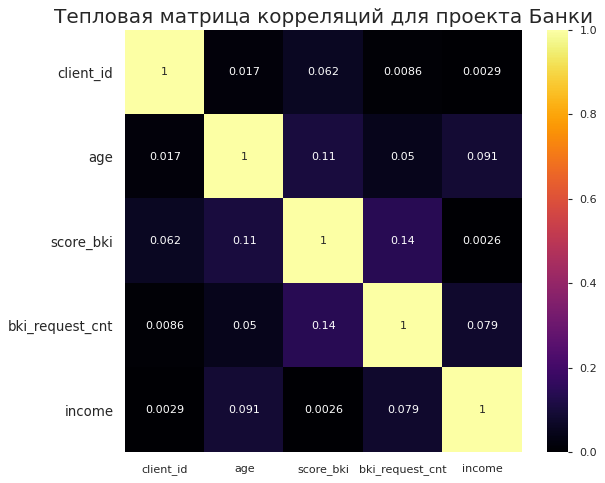

In [650]:
plt.figure(figsize=(8, 7), dpi= 80)
sns.heatmap(df[col_num].corr().abs(), vmin=0, vmax=1, annot=True, cmap = 'inferno')

# Decorations
plt.title('Тепловая матрица корреляций для проекта Банки', fontsize=18)
plt.xticks(fontsize=10)
plt.yticks(fontsize=12)
plt.show()

Существенных корреляций нет, все столбцы можно оставить.

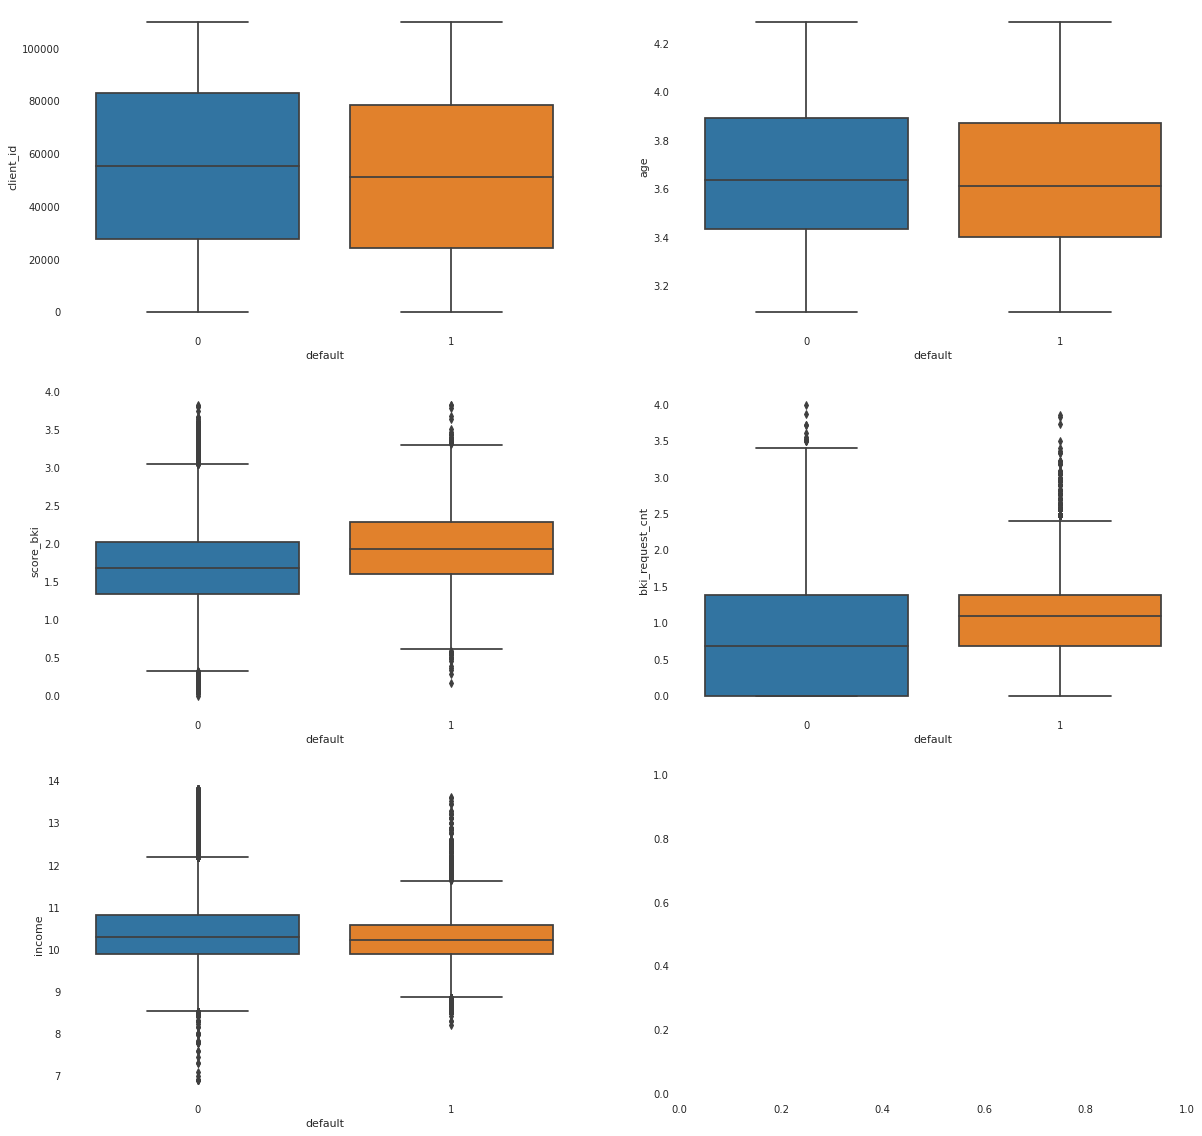

In [651]:
fig, axes = plt.subplots(3, 2, figsize=(20,20))
axes = axes.flatten()
for i in range(len(col_num)):
    sns.boxplot(x="default", y=col_num[i], data=df, ax=axes[i])

Посмотрим рейтинг столбцов по важности.

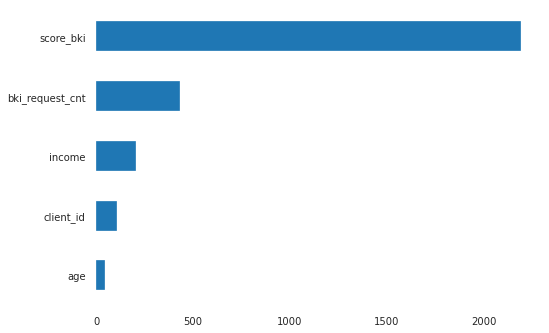

In [652]:
imp_num = Series(f_classif(df[col_num], df['default'])[0], index = col_num)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh')

### 2.3.2 Рассмотрим бинарные и категориальные признаки

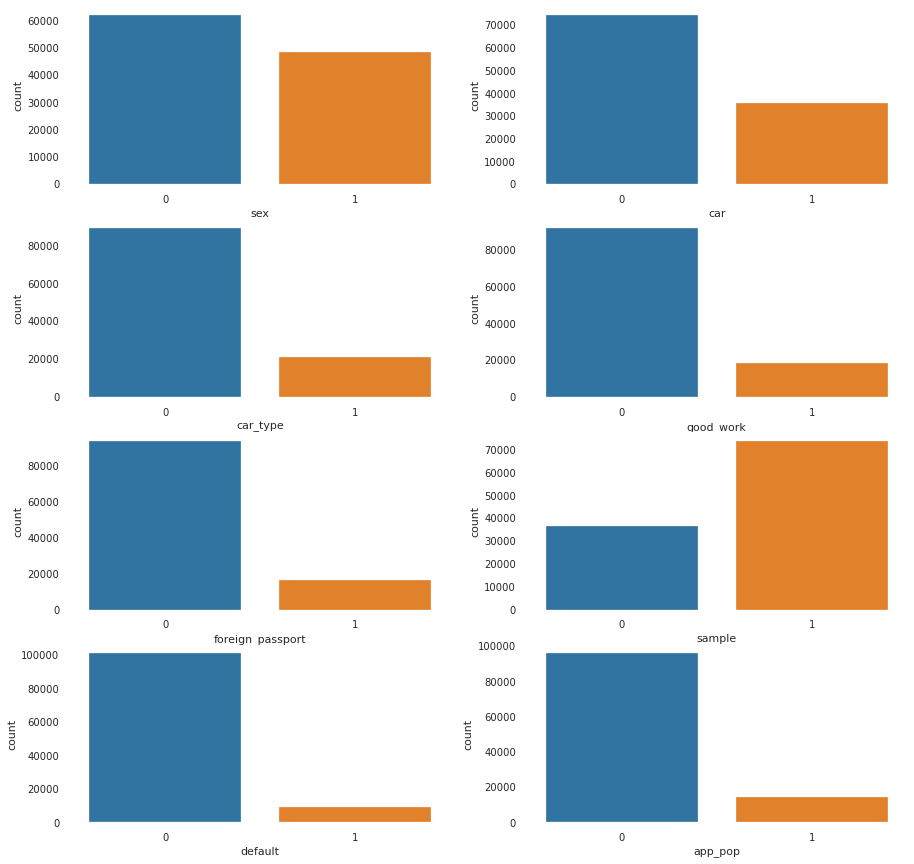

In [653]:
fig, axes = plt.subplots(4, 2, figsize=(15,15))
axes = axes.flatten()
for i in range(len(col_bin)):
    sns.countplot(x=col_bin[i], data=df, ax=axes[i])
  

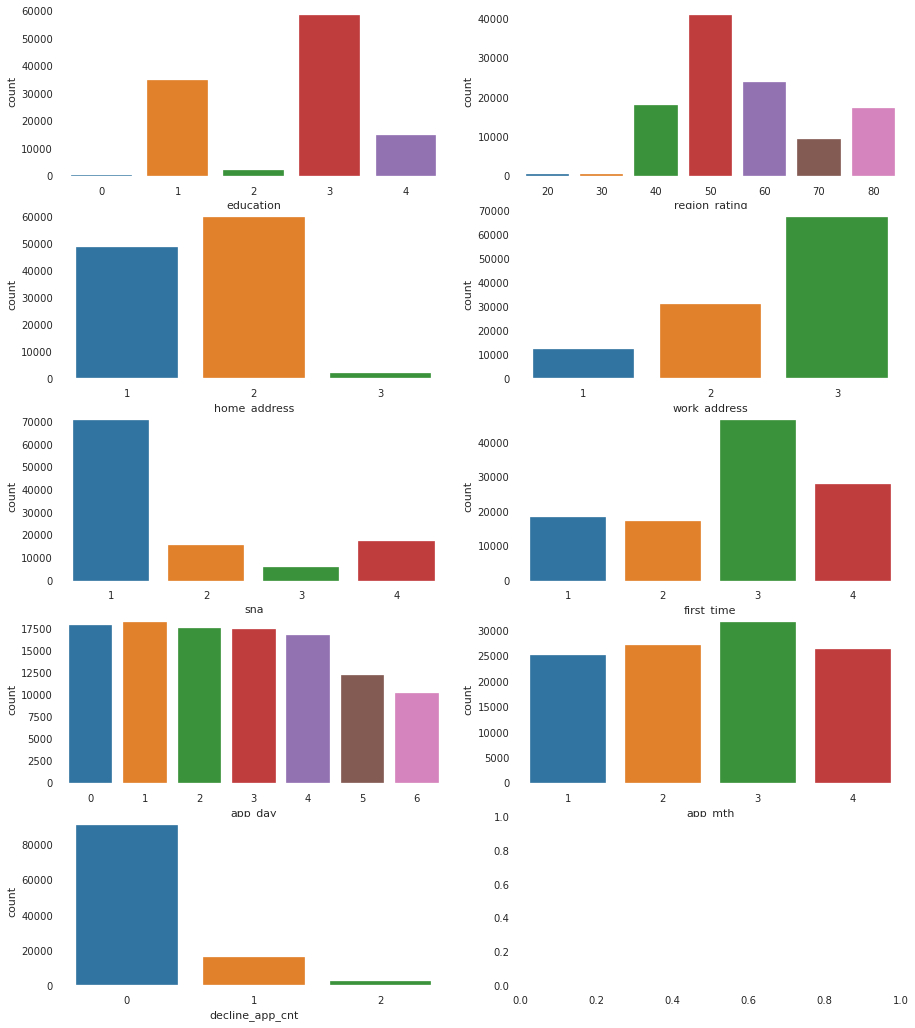

In [654]:
fig, axes = plt.subplots(5, 2, figsize=(15,18))
axes = axes.flatten()
for j in range(len(col_cat)):
    sns.countplot(x=col_cat[j], data=df, ax=axes[j]) 

Рассмотрим распределение столбцов по важности

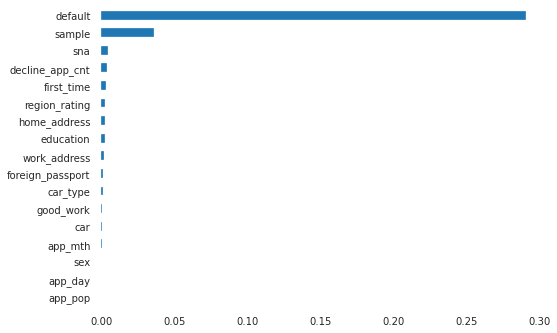

In [655]:
imp_cat = Series(mutual_info_classif(
    df[col_bin + col_cat], df['default'], 
    discrete_features =True
), index = col_bin + col_cat)

imp_cat.sort_values(inplace = True)
imp_cat.plot(kind = 'barh')

Хотя рейтинг показывает, что влияние некоторых столбцов ничтожно, но пока ничего удалять не будем.

In [656]:
#Перекодируем категориальные переменные в бинарные
df = pd.get_dummies(df, columns=col_cat, dummy_na=False)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110148 entries, 0 to 110147
Data columns (total 53 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   client_id          110148 non-null  int64  
 1   sex                110148 non-null  int64  
 2   age                110148 non-null  float64
 3   car                110148 non-null  int64  
 4   car_type           110148 non-null  int64  
 5   good_work          110148 non-null  int64  
 6   score_bki          110148 non-null  float64
 7   bki_request_cnt    110148 non-null  float64
 8   income             110148 non-null  float64
 9   foreign_passport   110148 non-null  int64  
 10  sample             110148 non-null  int64  
 11  default            110148 non-null  int64  
 12  app_pop            110148 non-null  int64  
 13  education_0        110148 non-null  uint8  
 14  education_1        110148 non-null  uint8  
 15  education_2        110148 non-null  uint8  
 16  ed

In [657]:
df.head()

client_id  sex       age  car  car_type  good_work  score_bki  \
0      74835    1  3.401197    1         1          0   1.352703   
1      17527    0  3.688879    0         0          0   2.119587   
2      75683    1  3.931826    1         1          0   1.933247   
3      26883    1  4.043051    0         0          0   1.250404   
4      28862    0  3.663562    0         0          0   1.137084   

   bki_request_cnt     income  foreign_passport  ...  app_day_4  app_day_5  \
0         1.386294  10.819798                 0  ...          0          1   
1         1.098612   8.517393                 0  ...          1          0   
2         0.693147  10.308986                 1  ...          0          0   
3         0.693147   9.741027                 0  ...          0          0   
4         0.000000  11.695255                 0  ...          0          0   

   app_day_6  app_mth_1  app_mth_2  app_mth_3  app_mth_4  decline_app_cnt_0  \
0          0          0          0          1          0                  1   
1          0          1          0          0          0                  0   
2          1          0          0          1          0                  1   
3          0          0          1          0          0                  1   
4          0          0          1          0          0                  1   

   decline_app_cnt_1  decline_app_cnt_2  
0                  0                  0  
1                  0                  1  
2                  0                  0  
3                  0                  0  
4                  0                  0  

[5 rows x 53 columns]

# 3. Работа с моделью

## 3.1 Подготовка датасета

Разделим датасет обратно на тестовые и тренировочные данные. Обучение и тестирование модели будет производиться на тренировочных данных. Из тестового датасета отдельно сохраним данные с клиентскими id

In [658]:
df_train = df.query('sample == 1').drop(['sample', 'client_id'], axis=1)
df_test = df.query('sample == 0').drop(['default'], axis=1)
id_sub = df_test[['client_id', 'sample']]

In [659]:
df_test.drop(['client_id', 'sample'], axis = 1, inplace=True)
id_sub.drop(['sample'], axis=1, inplace=True)

/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:4170: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [660]:
y = df_train['default']
X = df_train.drop(['default'], axis=1)

In [661]:
X_train, X_test, y_train, y_test = train_test_split(X,y , test_size=0.20, random_state=random_seed)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((59039, 50), (14760, 50), (59039,), (14760,))

## 3.2 Модели
### 3.2.1 Простая модель логистической регрессии без гиперпараметров

In [662]:
model_1 = LogisticRegression(max_iter=1000, random_state=random_seed)
model_1.fit(X_train, y_train)

# Предсказываем вероятность и значения целевой переменной
y_pred_prob = model_1.predict_proba(X_test)[:,1]
y_pred = model_1.predict(X_test)

# Оценка качества модели
metrics_total(y_test, y_pred, y_pred_prob)


Metrics        Result  \
P                Positive   1827.000000   
N                Negative  12933.000000   
TP          True positive     47.000000   
TN          True Negative  12874.000000   
FP         False Positive     59.000000   
FN         False Negative   1780.000000   
Accuracy         Accuracy      0.875407   
Precision       Precision      0.443396   
Recall             Recall      0.025725   
F1-score           F-мера      0.048629   
ROC_AUC           ROC_AUC      0.744597   

                                        Description  
P                                            Дефолт  
N                                       БЕЗ дефолта  
TP                                Истинно дефолтные  
TN                             Истинно НЕ дефолтные  
FP                                  Ложно дефолтные  
FN                               Ложно НЕ дефолтные  
Accuracy             Accuracy=(TP+TN)/(TP+TN+FP+FN)  
Precision                     Точность = TP/(TP+FP)  
Recall                         Полнота = TP/(TP+FN)  
F1-score   Среднее гармоническое Precision и Recall  
ROC_AUC                                     ROC-AUC

In [663]:
#Создадим датафрейм , в котором будем собирать для сравнения данные по всем моделям
lst_metrics = ['Accuracy', 'Precision', 'Recall', 'F1-score', 'ROC_AUC']
df_comp = pd.DataFrame(lst_metrics)
df_comp.columns = ['Metrics']
df_comp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5 entries, 0 to 4
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Metrics  5 non-null      object
dtypes: object(1)
memory usage: 168.0+ bytes


In [664]:
df_comp = cumulated_res(df_comp, 'model_1', y_test, y_pred, y_pred_prob)
df_comp

Metrics   model_1
0   Accuracy  0.875407
1  Precision  0.443396
2     Recall  0.025725
3   F1-score  0.048629
4    ROC_AUC  0.744597

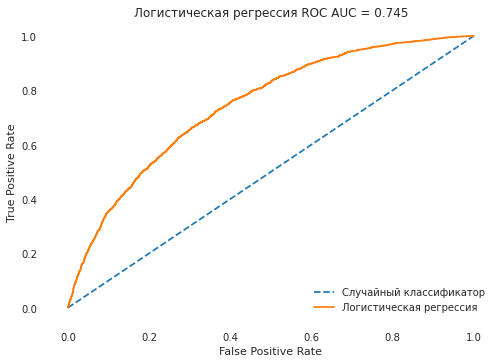

In [665]:
#Кривая ROC_AUC
roc_curv(y_test, y_pred_prob)

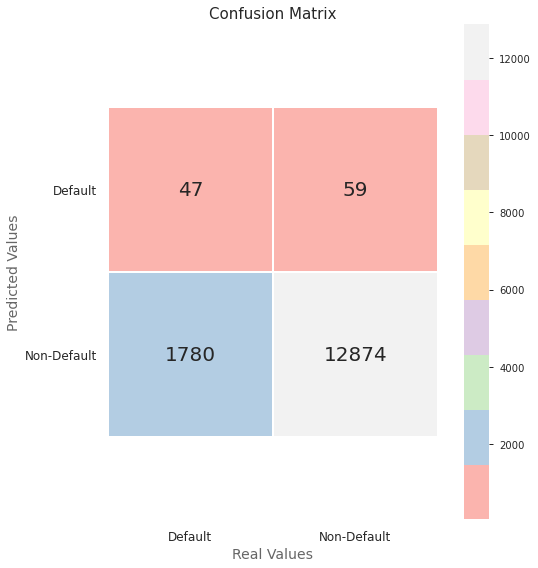

In [666]:
#Confusion matrix
conf_matr(y_test, y_pred)

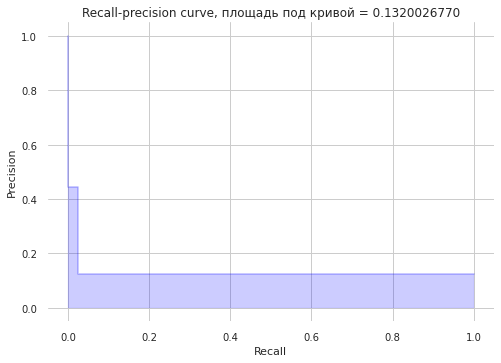

In [667]:
#Кривая precision - recall
recall_precision_plot(y_test, y_pred)

Хотя данные по Precision и Recall не так плохи,  однако показатель F-меры и Accuracy очень низкий. Попробуем улучшить модель. 

### 3.2.2 Модель логистической регрессии с отбалансированными признаками
Добавим балансировку признаков и посмотрим, как это повлияет на модель

In [668]:
model_2 = LogisticRegression(class_weight='balanced', max_iter=1000, random_state=random_seed)
model_2.fit(X_train, y_train)

# Предсказываем вероятность и значения целевой переменной
y_pred_prob = model_2.predict_proba(X_test)[:,1]
y_pred = model_2.predict(X_test)

# Оценка качества модели
metrics_total(y_test, y_pred, y_pred_prob)


Metrics        Result  \
P                Positive   1827.000000   
N                Negative  12933.000000   
TP          True positive   1253.000000   
TN          True Negative   8642.000000   
FP         False Positive   4291.000000   
FN         False Negative    574.000000   
Accuracy         Accuracy      0.670393   
Precision       Precision      0.226010   
Recall             Recall      0.685824   
F1-score           F-мера      0.339981   
ROC_AUC           ROC_AUC      0.744310   

                                        Description  
P                                            Дефолт  
N                                       БЕЗ дефолта  
TP                                Истинно дефолтные  
TN                             Истинно НЕ дефолтные  
FP                                  Ложно дефолтные  
FN                               Ложно НЕ дефолтные  
Accuracy             Accuracy=(TP+TN)/(TP+TN+FP+FN)  
Precision                     Точность = TP/(TP+FP)  
Recall                         Полнота = TP/(TP+FN)  
F1-score   Среднее гармоническое Precision и Recall  
ROC_AUC                                     ROC-AUC

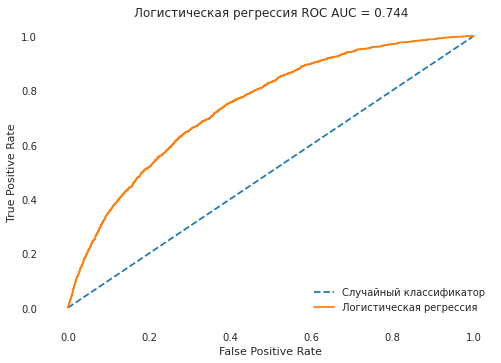

In [669]:
#Кривая ROC_AUC
roc_curv(y_test, y_pred_prob)

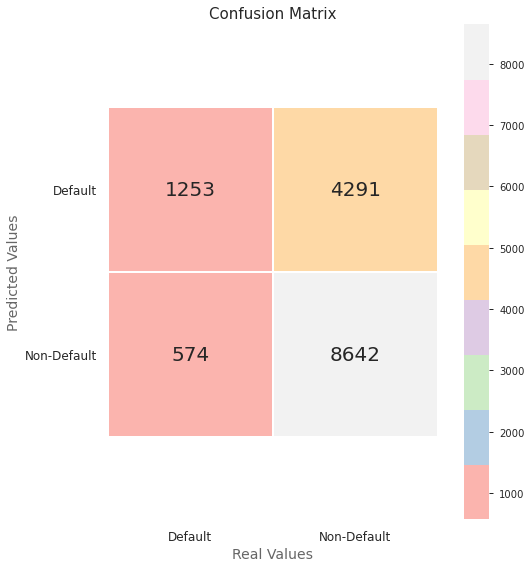

In [670]:
#Confusion matrix
conf_matr(y_test, y_pred)

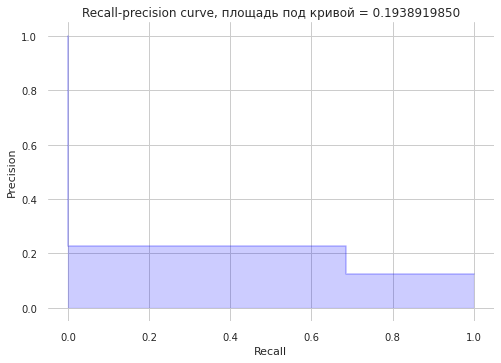

In [671]:
#Кривая precision - recall
recall_precision_plot(y_test, y_pred)

In [672]:
df_comp = cumulated_res(df_comp, 'model_2', y_test, y_pred, y_pred_prob)
df_comp

Metrics   model_1   model_2
0   Accuracy  0.875407  0.670393
1  Precision  0.443396  0.226010
2     Recall  0.025725  0.685824
3   F1-score  0.048629  0.339981
4    ROC_AUC  0.744597  0.744310

Получился очень интересный результат. Несмотря на то, что упали результаты по Accuracy и Precision упали, значительно выросла F-мера и Recall. По сути модель стала присваивать большему количеству заявителей статус вероятного дефолта, чем улучшила итог, но в целом стала менее точна,что сказалось на значени ROC-AUC, которое немного понизилось. Попробуем поработать над данными.

### 3.2.3 Подбор оптимальных признаков

Попробуем получить оптимальные параметры модели на небольшом количестве итераций и с достаточно большой дельтой останова tol1e-3.

In [673]:
model = LogisticRegression(random_state=random_seed)
iter_ = 50
epsilon_stop = 1e-3
param_grid = [
    {'penalty': ['l1'], 
     'solver': ['liblinear', 'lbfgs'], 
     'class_weight':['none', 'balanced'], 
     'multi_class': ['auto','ovr'], 
     'max_iter':[iter_],
     'tol':[epsilon_stop]},
    {'penalty': ['l2'], 
     'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'], 
     'class_weight':['none', 'balanced'], 
     'multi_class': ['auto','ovr'], 
     'max_iter':[iter_],
     'tol':[epsilon_stop]},
    {'penalty': ['none'], 
     'solver': ['newton-cg', 'lbfgs', 'sag', 'saga'], 
     'class_weight':['none', 'balanced'], 
     'multi_class': ['auto','ovr'], 
     'max_iter':[iter_],
     'tol':[epsilon_stop]},
]
gridsearch = GridSearchCV(model, param_grid, scoring='f1', n_jobs=-1, cv=5)
gridsearch.fit(X_train, y_train)
model = gridsearch.best_estimator_
##печатаем параметры
best_parameters = model.get_params()
for param_name in sorted(best_parameters.keys()):
        print('\t%s: %r' % (param_name, best_parameters[param_name]))
    

	C: 1.0
	class_weight: 'balanced'
	dual: False
	fit_intercept: True
	intercept_scaling: 1
	l1_ratio: None
	max_iter: 50
	multi_class: 'auto'
	n_jobs: None
	penalty: 'none'
	random_state: 42
	solver: 'saga'
	tol: 0.001
	verbose: 0
	warm_start: False


Запустим модель с полученными метриками

In [674]:
model_3 = LogisticRegression(C = 1.0, class_weight = 'balanced', dual = False, fit_intercept = True,
                             intercept_scaling = 1, l1_ratio = None, max_iter = 50, multi_class = 'auto',
                             n_jobs = None, penalty = 'none', random_state = 42, solver = 'saga', tol = 0.001,
                             verbose = 0, warm_start = False)
model_3.fit(X_train, y_train)
# Предсказываем вероятность и значения целевой переменной
y_pred_prob = model_3.predict_proba(X_test)[:,1]
y_pred = model_3.predict(X_test)

In [675]:
# Оценка качества модели
metrics_total(y_test, y_pred, y_pred_prob)

Metrics        Result  \
P                Positive   1827.000000   
N                Negative  12933.000000   
TP          True positive   1253.000000   
TN          True Negative   8639.000000   
FP         False Positive   4294.000000   
FN         False Negative    574.000000   
Accuracy         Accuracy      0.670190   
Precision       Precision      0.225888   
Recall             Recall      0.685824   
F1-score           F-мера      0.339843   
ROC_AUC           ROC_AUC      0.744298   

                                        Description  
P                                            Дефолт  
N                                       БЕЗ дефолта  
TP                                Истинно дефолтные  
TN                             Истинно НЕ дефолтные  
FP                                  Ложно дефолтные  
FN                               Ложно НЕ дефолтные  
Accuracy             Accuracy=(TP+TN)/(TP+TN+FP+FN)  
Precision                     Точность = TP/(TP+FP)  
Recall                         Полнота = TP/(TP+FN)  
F1-score   Среднее гармоническое Precision и Recall  
ROC_AUC                                     ROC-AUC

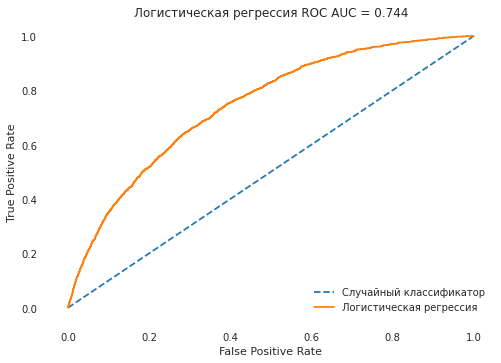

In [676]:
#Кривая ROC_AUC
roc_curv(y_test, y_pred_prob)

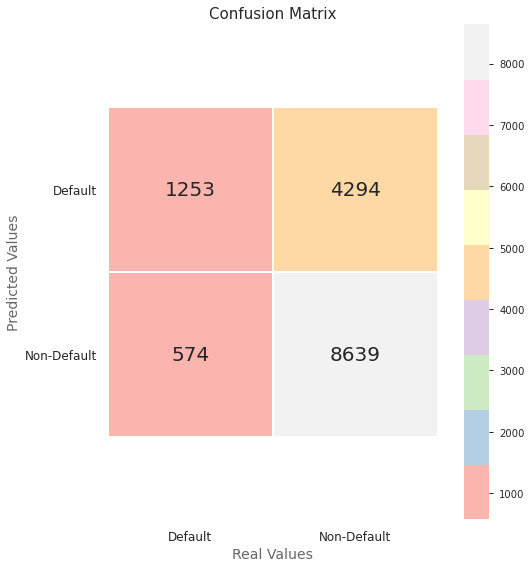

In [677]:
#Confusion matrix
conf_matr(y_test, y_pred)

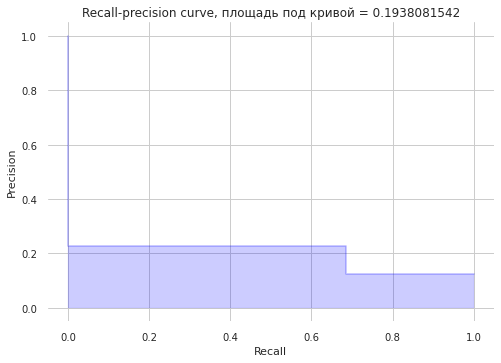

In [678]:
#Кривая precision - recall
recall_precision_plot(y_test, y_pred)

In [679]:
df_comp = cumulated_res(df_comp, 'model_3', y_test, y_pred, y_pred_prob)
df_comp

Metrics   model_1   model_2   model_3
0   Accuracy  0.875407  0.670393  0.670190
1  Precision  0.443396  0.226010  0.225888
2     Recall  0.025725  0.685824  0.685824
3   F1-score  0.048629  0.339981  0.339843
4    ROC_AUC  0.744597  0.744310  0.744298

Все данные слегка ухудшились, подобранные параметры оказались неэффективны.

### 3.2.4 Модель с усиленной регуляризацией

Попробуем усилить регуляризацию С до 0.5, увеличить количество итераций до 1000 и ввести штраф 

In [680]:
model_4 = LogisticRegression(C = 0.5, class_weight = 'balanced', dual = False, fit_intercept = True,
                             intercept_scaling = 1, l1_ratio = None, max_iter = 1000, multi_class = 'auto',
                             n_jobs = None, penalty = 'l2', random_state = 42, solver = 'saga', tol = 0.001,
                             verbose = 0, warm_start = False)
model_4.fit(X_train, y_train)
# Предсказываем вероятность и значения целевой переменной
y_pred_prob = model_4.predict_proba(X_test)[:,1]
y_pred = model_4.predict(X_test)

In [681]:
# Оценка качества модели
metrics_total(y_test, y_pred, y_pred_prob)

Metrics        Result  \
P                Positive   1827.000000   
N                Negative  12933.000000   
TP          True positive   1253.000000   
TN          True Negative   8640.000000   
FP         False Positive   4293.000000   
FN         False Negative    574.000000   
Accuracy         Accuracy      0.670257   
Precision       Precision      0.225929   
Recall             Recall      0.685824   
F1-score           F-мера      0.339889   
ROC_AUC           ROC_AUC      0.744347   

                                        Description  
P                                            Дефолт  
N                                       БЕЗ дефолта  
TP                                Истинно дефолтные  
TN                             Истинно НЕ дефолтные  
FP                                  Ложно дефолтные  
FN                               Ложно НЕ дефолтные  
Accuracy             Accuracy=(TP+TN)/(TP+TN+FP+FN)  
Precision                     Точность = TP/(TP+FP)  
Recall                         Полнота = TP/(TP+FN)  
F1-score   Среднее гармоническое Precision и Recall  
ROC_AUC                                     ROC-AUC

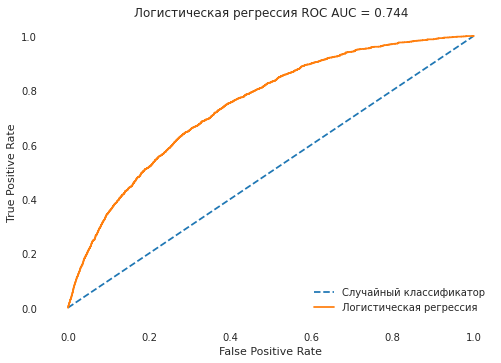

In [682]:
#Кривая ROC_AUC
roc_curv(y_test, y_pred_prob)

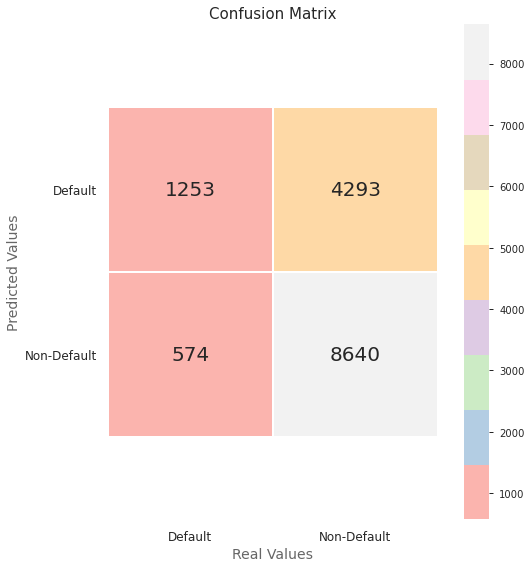

In [683]:
#Confusion matrix
conf_matr(y_test, y_pred)

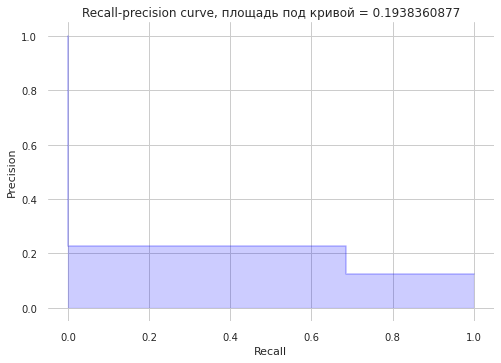

In [684]:
#Кривая precision - recall
recall_precision_plot(y_test, y_pred)

In [685]:
df_comp = cumulated_res(df_comp, 'model_4', y_test, y_pred, y_pred_prob)
df_comp

Metrics   model_1   model_2   model_3   model_4
0   Accuracy  0.875407  0.670393  0.670190  0.670257
1  Precision  0.443396  0.226010  0.225888  0.225929
2     Recall  0.025725  0.685824  0.685824  0.685824
3   F1-score  0.048629  0.339981  0.339843  0.339889
4    ROC_AUC  0.744597  0.744310  0.744298  0.744347

Появились незначительные улучшения. Попробуем убрать неэффективные признаки, возможно, это поможет улучшить результат модели.  В дальнейшем в качестве параметров модели будем брать параметры из 4 попытки.

### 3.2.5 Очистка модели от признаков с нулевыми коэффициентами
Проведём l1 регуляризацию.

In [686]:
model_5 = LogisticRegression(random_state=random_seed, 
                           C=1, 
                           class_weight= 'balanced', 
                           penalty= 'l1', 
                           solver = 'liblinear', 
                           )

model_5.fit(X_train, y_train)
df_coef = pd.DataFrame(np.hstack((np.array(X_train.columns).reshape(50,1), model_5.coef_.reshape(50,1))), columns = ['col', 'coef'])


In [687]:
#Составление списка признаков, отсортированного по значимости (абсолютному значению коэффициента)
df_coef['abs_coef'] = np.abs(df_coef.coef)
df_coef.sort_values(['abs_coef'], ascending = False)


col        coef    abs_coef
21   region_rating_80    -1.10132     1.10132
5           score_bki    0.969898    0.969898
10        education_0   -0.798627    0.798627
20   region_rating_70   -0.766015    0.766015
22     home_address_1   -0.541688    0.541688
12        education_2   -0.530211    0.530211
24     home_address_3   -0.475199    0.475199
47  decline_app_cnt_0   -0.443743    0.443743
25     work_address_1   -0.418075    0.418075
46          app_mth_4   -0.373329    0.373329
15   region_rating_20    0.348266    0.348266
19   region_rating_60    -0.34426     0.34426
28              sna_1   -0.292006    0.292006
0                 sex    0.285182    0.285182
6     bki_request_cnt    0.282599    0.282599
35       first_time_4    -0.27677     0.27677
3            car_type   -0.276157    0.276157
11        education_1   -0.260065    0.260065
18   region_rating_50   -0.230764    0.230764
16   region_rating_30    0.227267    0.227267
8    foreign_passport   -0.222976    0.222976
4           good_work    -0.19577     0.19577
31              sna_4     0.17345     0.17345
13        education_3    0.148141    0.148141
26     work_address_2   -0.119265    0.119265
1                 age   -0.114234    0.114234
49  decline_app_cnt_2    0.109329    0.109329
34       first_time_3     -0.1033      0.1033
33       first_time_2   0.0834302   0.0834302
48  decline_app_cnt_1  -0.0814775   0.0814775
40          app_day_4  -0.0623221   0.0623221
30              sna_3  -0.0610647   0.0610647
9             app_pop   0.0596802   0.0596802
43          app_mth_1   0.0594752   0.0594752
39          app_day_3   0.0554217   0.0554217
45          app_mth_3  -0.0535451   0.0535451
17   region_rating_40   0.0394003   0.0394003
38          app_day_2  -0.0256693   0.0256693
36          app_day_0  -0.0187446   0.0187446
2                 car  -0.0118022   0.0118022
23     home_address_2  0.00900633  0.00900633
41          app_day_5   0.0084192   0.0084192
7              income -0.00679345  0.00679345
42          app_day_6 -0.00282926  0.00282926
14        education_4           0           0
44          app_mth_2           0           0
37          app_day_1           0           0
29              sna_2           0           0
27     work_address_3           0           0
32       first_time_1           0           0

Исключим признаки с нулевыми коэффициентами из модели.

In [688]:
#Список эффективных признаков
lst_features = list(df_coef[df_coef['coef']!=0]['col'])
lst_features

['sex',
 'age',
 'car',
 'car_type',
 'good_work',
 'score_bki',
 'bki_request_cnt',
 'income',
 'foreign_passport',
 'app_pop',
 'education_0',
 'education_1',
 'education_2',
 'education_3',
 'region_rating_20',
 'region_rating_30',
 'region_rating_40',
 'region_rating_50',
 'region_rating_60',
 'region_rating_70',
 'region_rating_80',
 'home_address_1',
 'home_address_2',
 'home_address_3',
 'work_address_1',
 'work_address_2',
 'sna_1',
 'sna_3',
 'sna_4',
 'first_time_2',
 'first_time_3',
 'first_time_4',
 'app_day_0',
 'app_day_2',
 'app_day_3',
 'app_day_4',
 'app_day_5',
 'app_day_6',
 'app_mth_1',
 'app_mth_3',
 'app_mth_4',
 'decline_app_cnt_0',
 'decline_app_cnt_1',
 'decline_app_cnt_2']

In [689]:
X_train_new = X_train[lst_features]
df_test_new = df_test[lst_features]
X_test_new = X_test[lst_features]

In [690]:
model_5 = LogisticRegression(C = 0.5, class_weight = 'balanced', dual = False, fit_intercept = True,
                             intercept_scaling = 1, l1_ratio = None, max_iter = 1000, multi_class = 'auto',
                             n_jobs = None, penalty = 'l2', random_state = 42, solver = 'saga', tol = 0.001,
                             verbose = 0, warm_start = False)
model_5.fit(X_train_new, y_train)
# Предсказываем вероятность и значения целевой переменной
y_pred_prob = model_5.predict_proba(X_test_new)[:,1]
y_pred = model_5.predict(X_test_new)

In [691]:
# Оценка качества модели
metrics_total(y_test, y_pred, y_pred_prob)

Metrics        Result  \
P                Positive   1827.000000   
N                Negative  12933.000000   
TP          True positive   1253.000000   
TN          True Negative   8640.000000   
FP         False Positive   4293.000000   
FN         False Negative    574.000000   
Accuracy         Accuracy      0.670257   
Precision       Precision      0.225929   
Recall             Recall      0.685824   
F1-score           F-мера      0.339889   
ROC_AUC           ROC_AUC      0.744348   

                                        Description  
P                                            Дефолт  
N                                       БЕЗ дефолта  
TP                                Истинно дефолтные  
TN                             Истинно НЕ дефолтные  
FP                                  Ложно дефолтные  
FN                               Ложно НЕ дефолтные  
Accuracy             Accuracy=(TP+TN)/(TP+TN+FP+FN)  
Precision                     Точность = TP/(TP+FP)  
Recall                         Полнота = TP/(TP+FN)  
F1-score   Среднее гармоническое Precision и Recall  
ROC_AUC                                     ROC-AUC

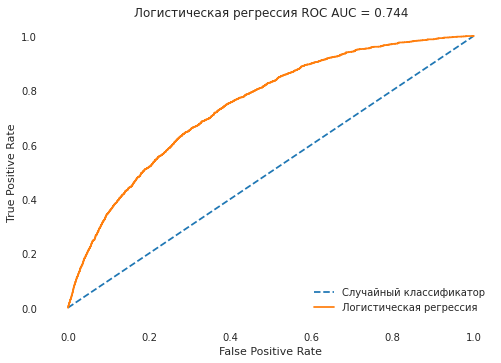

In [692]:
#Кривая ROC_AUC
roc_curv(y_test, y_pred_prob)

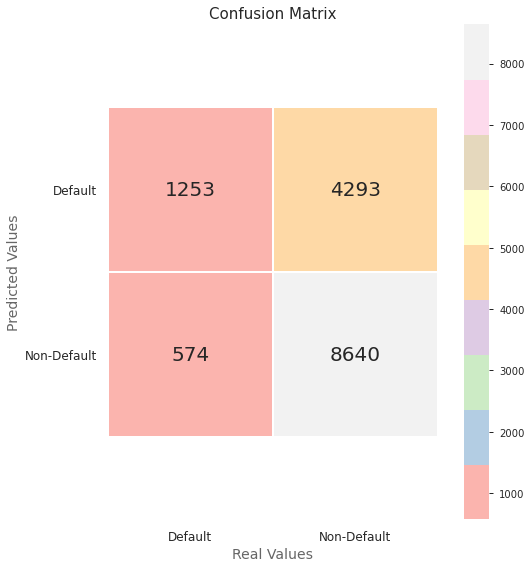

In [693]:
#Confusion matrix
conf_matr(y_test, y_pred)

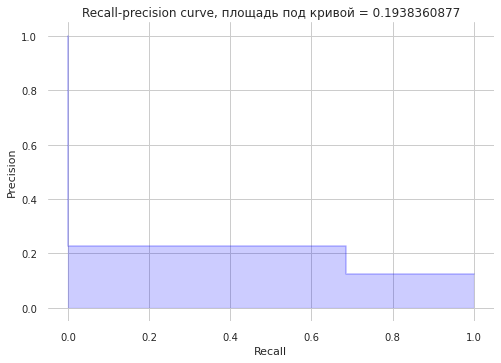

In [694]:
#Кривая precision - recall
recall_precision_plot(y_test, y_pred)

In [695]:
df_comp = cumulated_res(df_comp, 'model_5', y_test, y_pred, y_pred_prob)
df_comp

Metrics   model_1   model_2   model_3   model_4   model_5
0   Accuracy  0.875407  0.670393  0.670190  0.670257  0.670257
1  Precision  0.443396  0.226010  0.225888  0.225929  0.225929
2     Recall  0.025725  0.685824  0.685824  0.685824  0.685824
3   F1-score  0.048629  0.339981  0.339843  0.339889  0.339889
4    ROC_AUC  0.744597  0.744310  0.744298  0.744347  0.744348

Ощутимых изменений не произошло. Применим более серьёзный метод.

### 3.2.6 Модель с признаками, выбранными методом RFE
Для отбора признаков применим метод рекурсивного исключения признаков (recursive feature elimination, RFE). Алгоритм действует так: модель обучается на исходном наборе признаков и оценивает их значимость, затем исключается один или несколько наименее значимых признаков, модель обучается на оставшихся признаках, и так далее, пока не останется заданное количество лучших признаков. Отберём 20 лучших. Обрабатывать будем датасет с уже исключёнными признаками.

In [696]:
X_train = X_train_new
df_test = df_test_new
X_test = X_test_new

In [697]:
#Обучим модель и выделим 20 лучших признаков. Им будет присвоен ранг 1
logreg = LogisticRegression(random_state=random_seed, max_iter=1000)
rfe = RFE(logreg, 20)
fit = rfe.fit(X_train, y_train)

df_features = pd.DataFrame(df_test.columns, fit.ranking_)


/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_features_to_select=20 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


In [698]:
df_features.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 44 entries, 1 to 3
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   0       44 non-null     object
dtypes: object(1)
memory usage: 704.0+ bytes


In [699]:
#Составим список отобранных признаков
df_good_features = df_features.loc[1]
lst_features = list(df_good_features[0])
lst_features

['sex',
 'car_type',
 'good_work',
 'score_bki',
 'bki_request_cnt',
 'foreign_passport',
 'education_0',
 'education_1',
 'education_2',
 'region_rating_20',
 'region_rating_30',
 'region_rating_40',
 'region_rating_70',
 'region_rating_80',
 'home_address_2',
 'work_address_1',
 'sna_1',
 'first_time_4',
 'app_mth_4',
 'decline_app_cnt_0']

In [700]:
#Оставим в датасетах только необходимые признаки
X_train_new = X_train[lst_features]
df_test_new = df_test[lst_features]
X_test_new = X_test[lst_features]

In [701]:
model_6 = LogisticRegression(C = 0.5, class_weight = 'balanced', dual = False, fit_intercept = True,
                             intercept_scaling = 1, l1_ratio = None, max_iter = 1000, multi_class = 'auto',
                             n_jobs = None, penalty = 'l2', random_state = random_seed, solver = 'saga', tol = 0.001,
                             verbose = 0, warm_start = False)
model_6.fit(X_train_new, y_train)
# Предсказываем вероятность и значения целевой переменной
y_pred_prob = model_6.predict_proba(X_test_new)[:,1]
y_pred = model_6.predict(X_test_new)

In [702]:
# Оценка качества модели
metrics_total(y_test, y_pred, y_pred_prob)

Metrics        Result  \
P                Positive   1827.000000   
N                Negative  12933.000000   
TP          True positive   1259.000000   
TN          True Negative   8594.000000   
FP         False Positive   4339.000000   
FN         False Negative    568.000000   
Accuracy         Accuracy      0.667547   
Precision       Precision      0.224902   
Recall             Recall      0.689108   
F1-score           F-мера      0.339125   
ROC_AUC           ROC_AUC      0.740807   

                                        Description  
P                                            Дефолт  
N                                       БЕЗ дефолта  
TP                                Истинно дефолтные  
TN                             Истинно НЕ дефолтные  
FP                                  Ложно дефолтные  
FN                               Ложно НЕ дефолтные  
Accuracy             Accuracy=(TP+TN)/(TP+TN+FP+FN)  
Precision                     Точность = TP/(TP+FP)  
Recall                         Полнота = TP/(TP+FN)  
F1-score   Среднее гармоническое Precision и Recall  
ROC_AUC                                     ROC-AUC

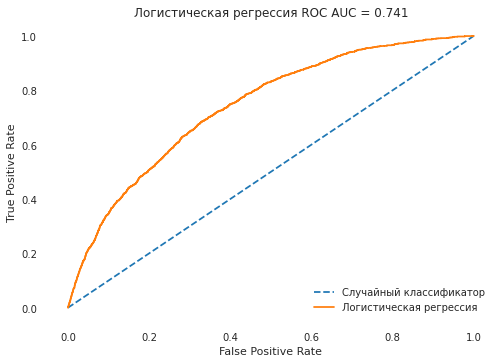

In [703]:
#Кривая ROC_AUC
roc_curv(y_test, y_pred_prob)

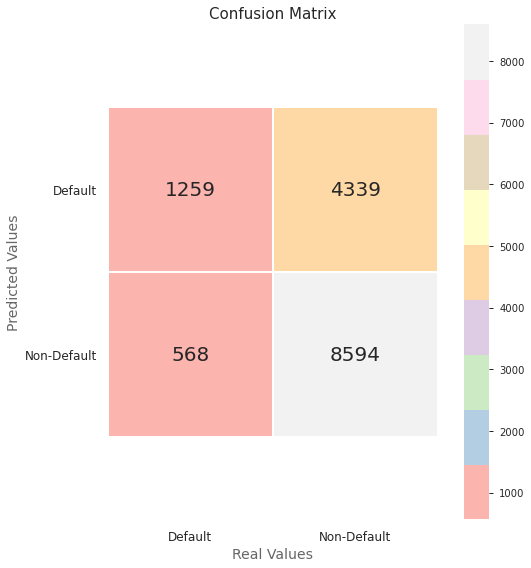

In [704]:
#Confusion matrix
conf_matr(y_test, y_pred)

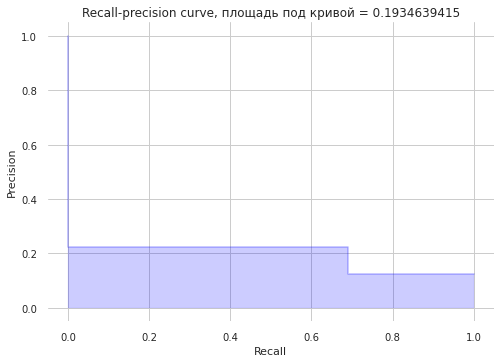

In [705]:
#Кривая precision - recall
recall_precision_plot(y_test, y_pred)

In [706]:
df_comp = cumulated_res(df_comp, 'model_6', y_test, y_pred, y_pred_prob)
df_comp

Metrics   model_1   model_2   model_3   model_4   model_5   model_6
0   Accuracy  0.875407  0.670393  0.670190  0.670257  0.670257  0.667547
1  Precision  0.443396  0.226010  0.225888  0.225929  0.225929  0.224902
2     Recall  0.025725  0.685824  0.685824  0.685824  0.685824  0.689108
3   F1-score  0.048629  0.339981  0.339843  0.339889  0.339889  0.339125
4    ROC_AUC  0.744597  0.744310  0.744298  0.744347  0.744348  0.740807

Итак, мы получили удивительную картину. Все параметры, за исключением Recall немного, но ухудшились. Мы видим, что самое значительное улучшение модель получила после балансировки признаков, хотя по сути одновременное ухудшение Accuracy и Precision означает, что мы не вскрыли настоящую закономерность и просто имеем лучший результат за счёт того, что модель не так смещена в сторону бОльшего итогового результата. Для дальнейшей обработки необходимы другие инструменты, как балансировка признаков путём удаления Oversamplinga, но временные рамки не позволяют нам сделать это в границах данного проекта. Поэтому отправим на Submission результаты модели №5.

# 4. Submission

In [707]:
X_final = df_test
y_pred_prob_f = model_5.predict_proba(X_final)[:,1]
y_pred_f = model_5.predict(X_final)

submit = id_sub
submit['default'] = y_pred_prob_f


In [708]:
submit.to_csv('submission.csv', index=False)

# 5. Заключение
Хотя модель по-прежнему нельзя назвать идеальной, тем не менее в процессе преобразований ключевые значения метрик были улучшены без малого в 30 раз. Применение дополнительных инструментов отбора признаков и их регуляризации уже не принесут такие значительные улучшения, однако будут играть именно на точность предсказания конретных величин, что в итоге выражается в значительных суммах. 